In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import time
from IPython.display import display, Latex
import corner
import camb
from datetime import datetime
%matplotlib notebook 

## A)

First, we start by looking at the data.

<IPython.core.display.Javascript object>


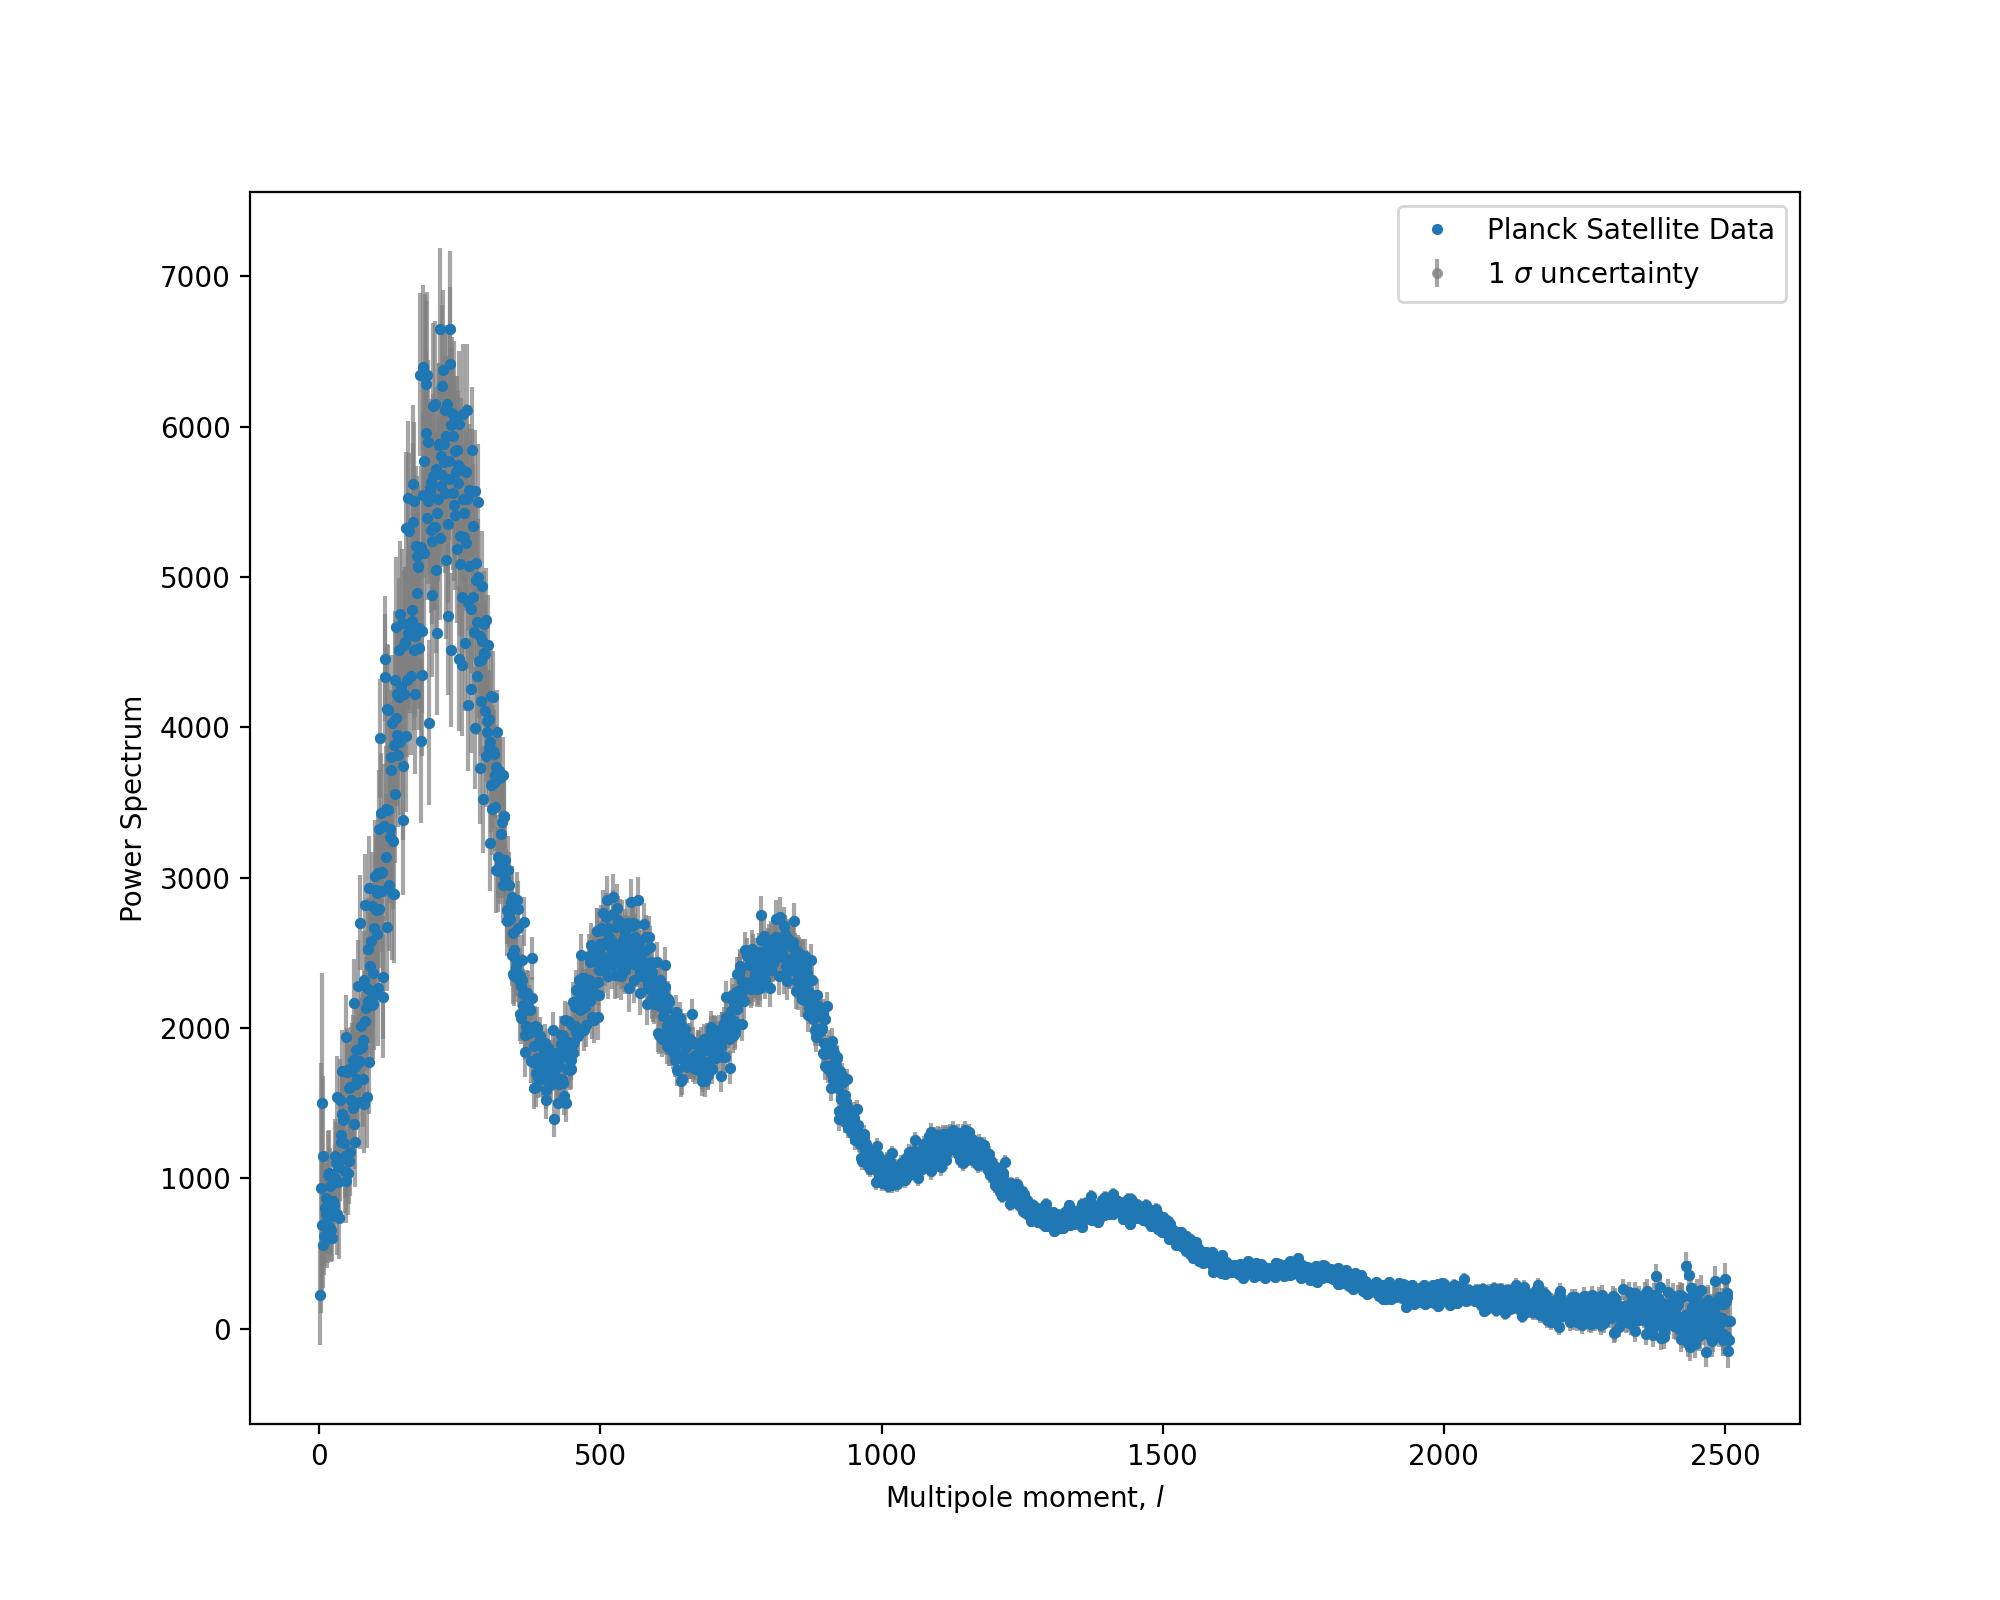

(2507, 2507)

In [2]:
data = np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt')
spec = data[:,1]
l = data[:,0]
#assume the errors are Gaussian and uncorrelated, and that the error on each point 
#is the average of the upper and lower errors
err_pnts = np.mean([data[:,2],data[:,3]],axis=0)

plt.figure(figsize=(10,8))
plt.plot(l,spec,'.',label='Planck Satellite Data')
plt.errorbar(l,spec,err_pnts,color='gray',fmt='.',alpha=0.7,label='1 $\sigma$ uncertainty',zorder=0)
plt.legend()
plt.xlabel('Multipole moment, $l$')
plt.ylabel('Power Spectrum')
plt.show

spec.size, err_pnts.size

Using Jon's script to download the spectrum and testing his parameters.

χ2 should be 2501 with sigma 70.7  for  2501  degrees of freedom.

For parameters Hubble constant = 60.0, Baryon density = 0.02, Dark matter density = 0.1, Optical depth = 0.05,           Primordial amplitude = 2e-09 and Primordial tilt = 1.0:
χ2 is  15267.937435709791


<IPython.core.display.Javascript object>


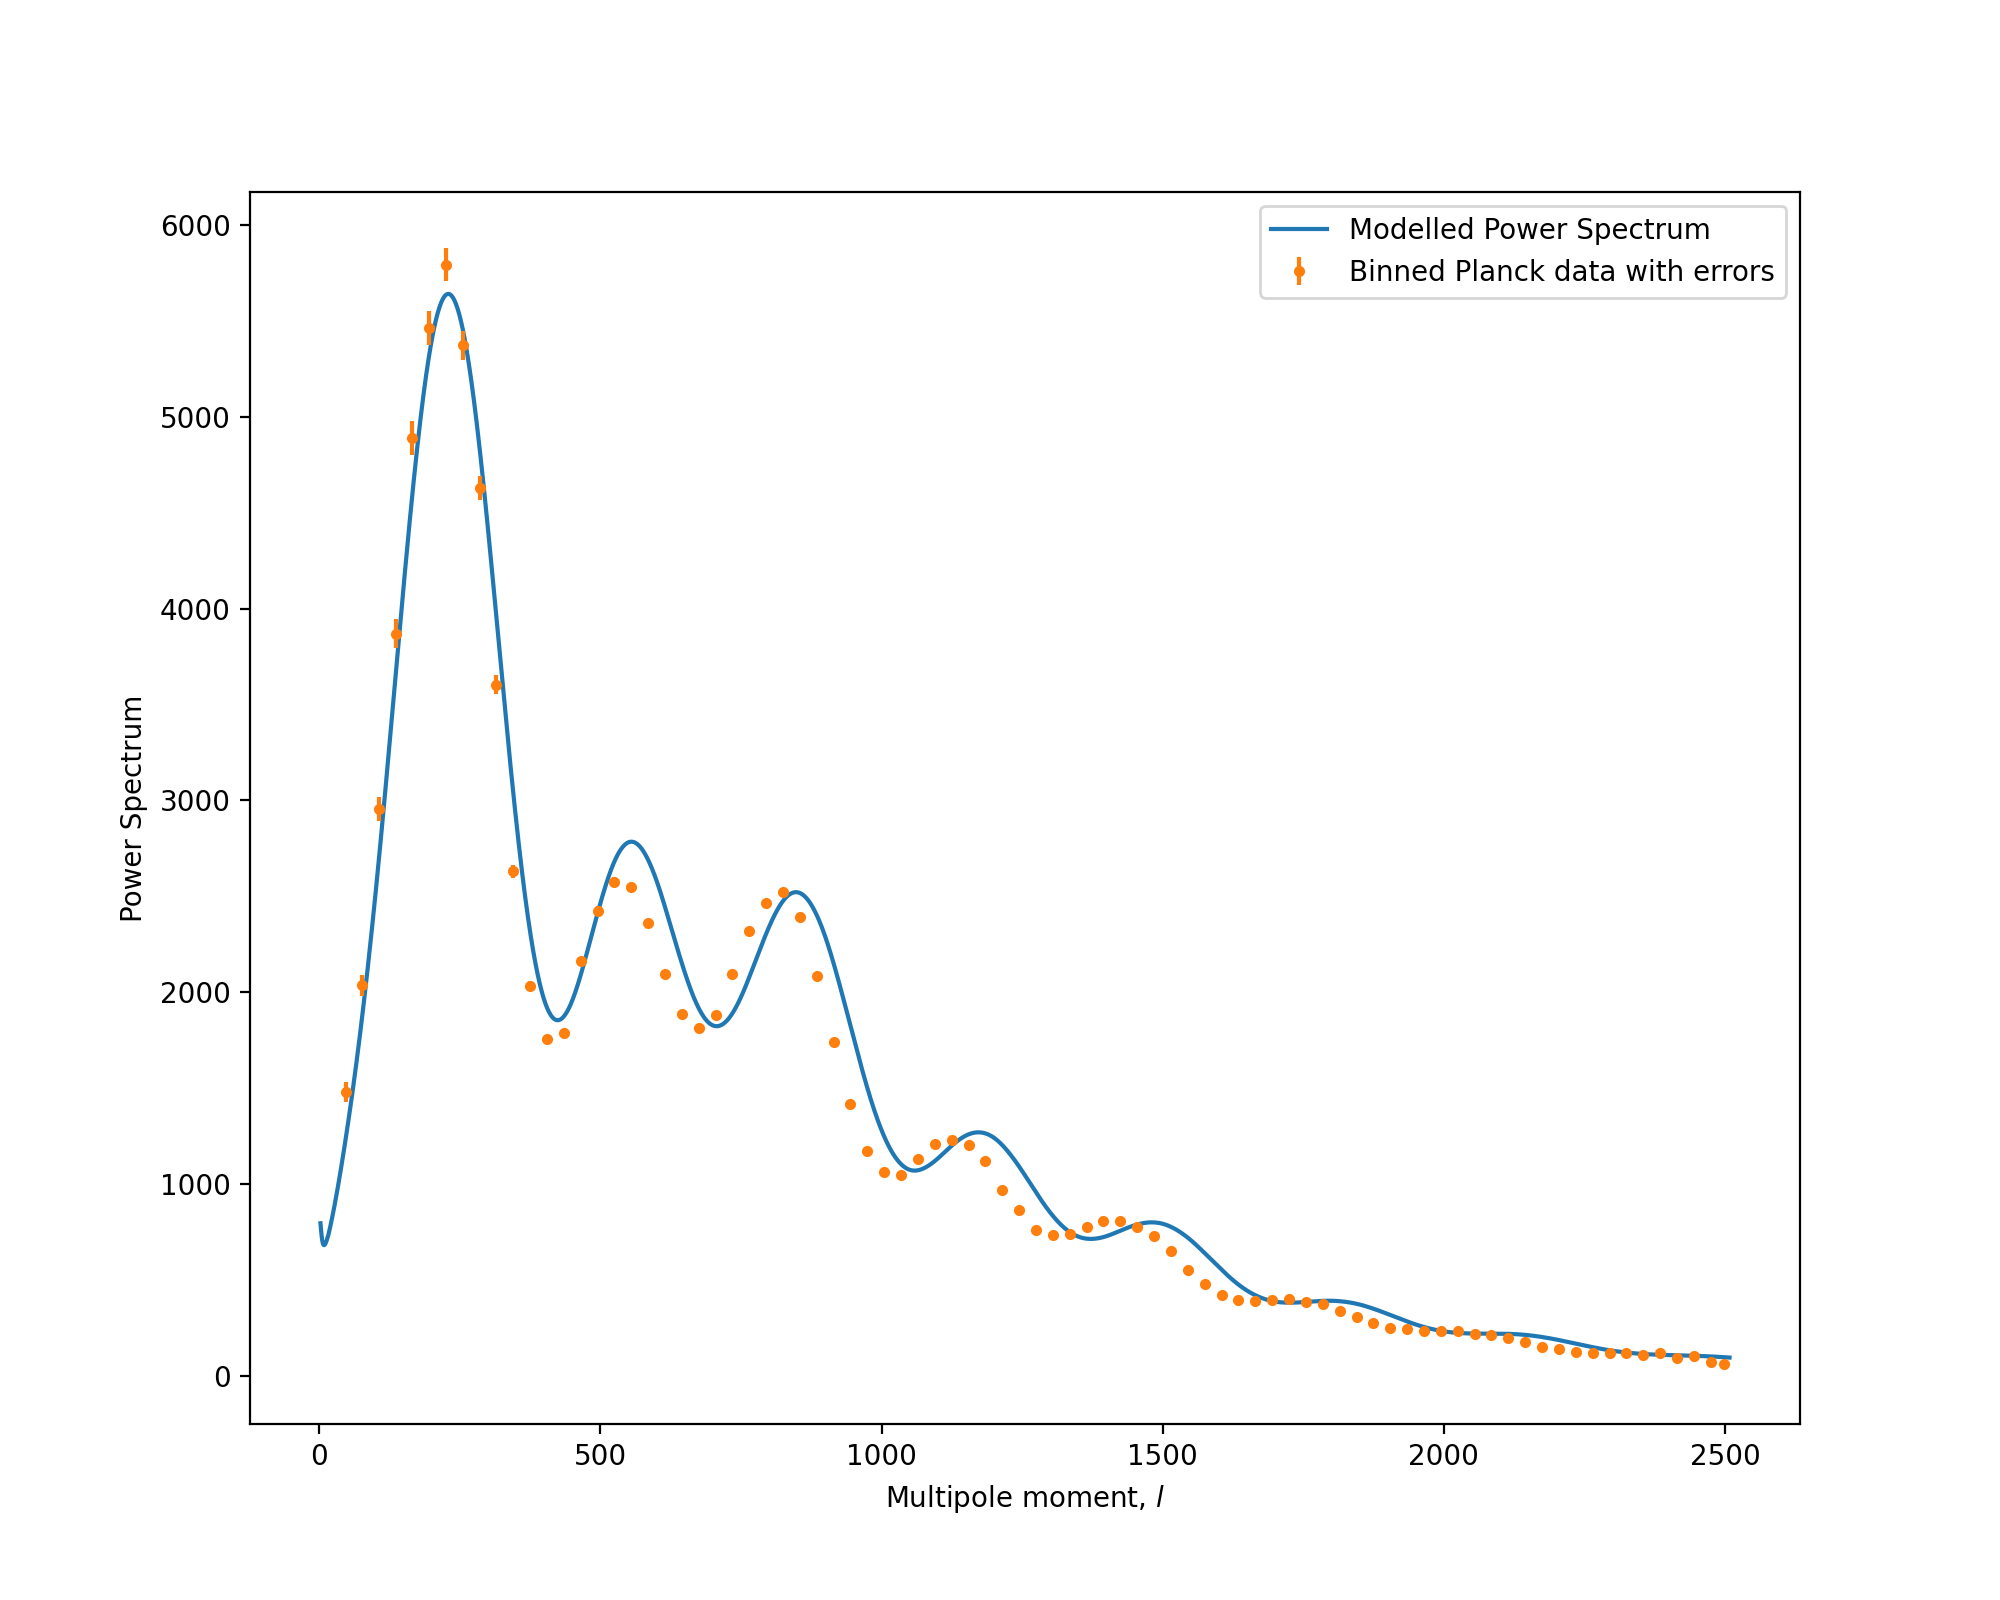

χ2 should be 2501 with sigma 70.7  for  2501  degrees of freedom.

For parameters Hubble constant = 69.0, Baryon density = 0.022, Dark matter density = 0.12, Optical depth = 0.06,           Primordial amplitude = 2.1e-09 and Primordial tilt = 0.95:
χ2 is  3272.2036739044693


<IPython.core.display.Javascript object>


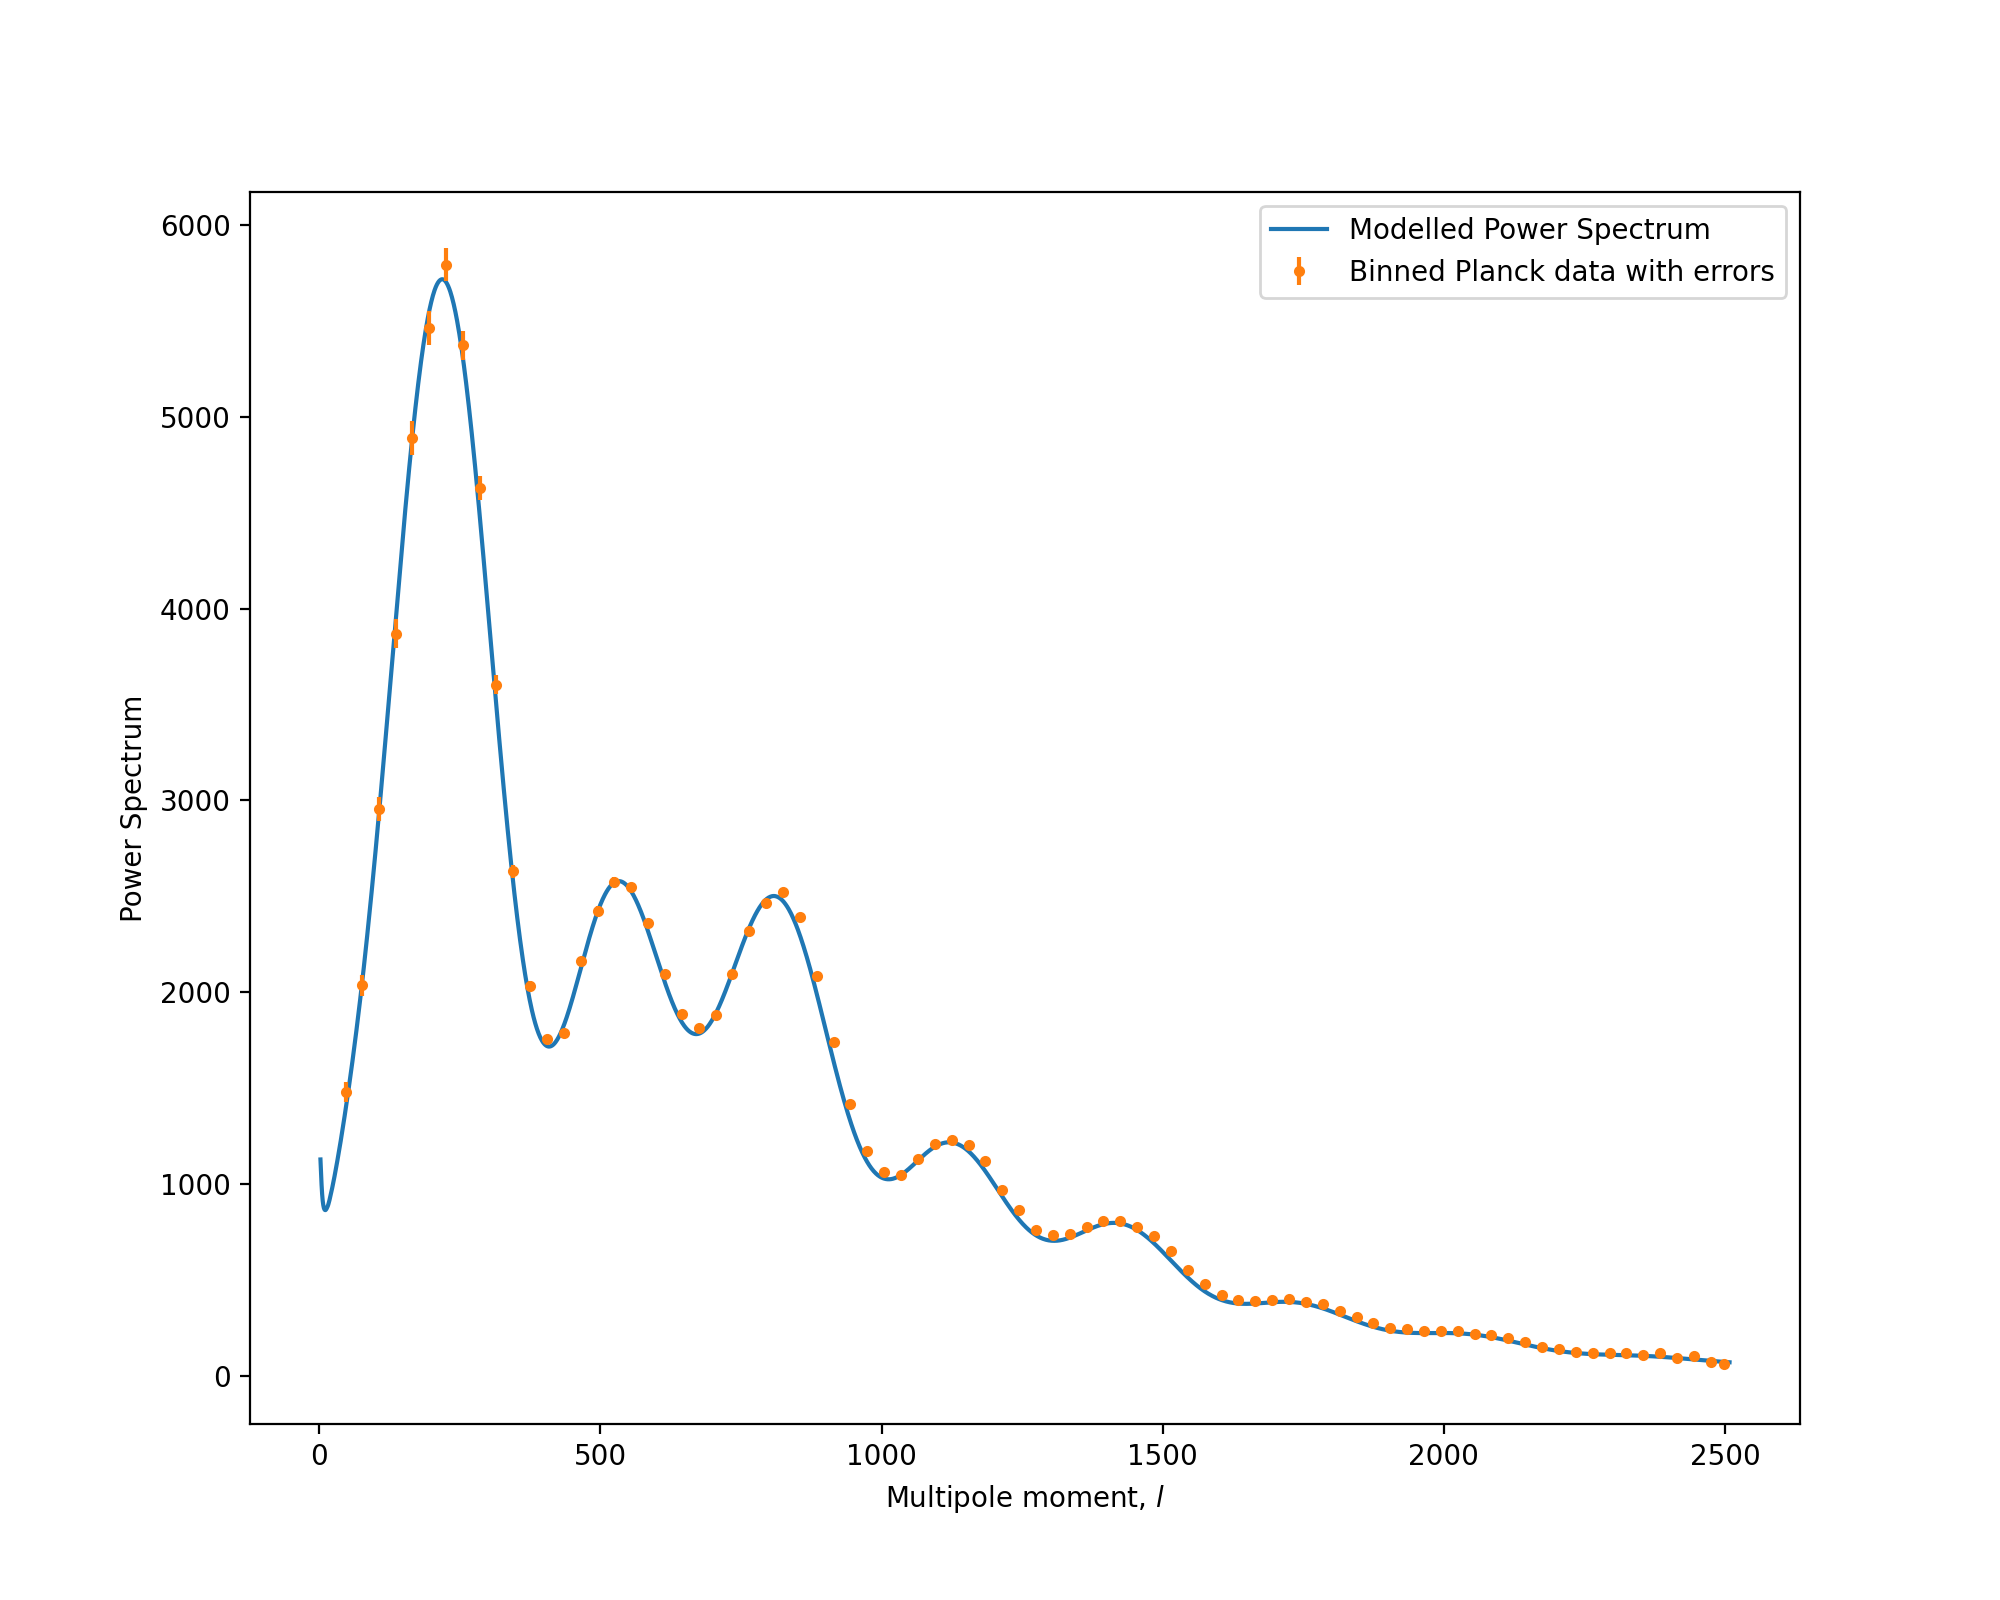

In [4]:
#Jon's script
def get_spectrum(pars,lmax=3000):
    #parameters
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5] 
    pars=camb.CAMBparams() #Storing the parameters as object to perform a CAMB calculation
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau) #set cosmology parameters
    pars.InitPower.set_params(As=As,ns=ns,r=0) 
    pars.set_for_lmax(lmax,lens_potential_accuracy=0) 
    results=camb.get_results(pars) #getting camb results for the parameters
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK') #selecting power spectra result
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt[2:] #removing the first two entries because CAMB starts from the monopole


#testing some parameters
pars1=np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0]) 
pars2=np.asarray([69, 0.022, 0.12, 0.06, 2.1e-9, 0.95])
testingpars=[pars1,pars2]

for pars in testingpars:
    model=get_spectrum(pars) #modelled camb with given params
    model=model[:len(spec)]
    resid=spec-model
    chisq=np.sum((resid/err_pnts)**2)
    print("χ2 should be",len(resid)-len(pars), "with sigma", f'{np.sqrt(2*(len(resid)-len(pars))):.3}'," for ",len(resid)-len(pars)," degrees of freedom.\n")
    print("For parameters Hubble constant = {}, Baryon density = {}, Dark matter density = {}, Optical depth = {}, \
          Primordial amplitude = {} and Primordial tilt = {}:".format(pars[0],pars[1],pars[2],pars[3],pars[4],pars[5]))
    print("χ2 is ",chisq)
    #read in a binned version of the Planck PS for plotting purposes
    planck_binned=np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt',skiprows=1)
    errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3]);
    plt.figure(figsize=(10,8))
    plt.plot(l,model,label='Modelled Power Spectrum')
    plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.',label='Binned Planck data with errors')
    plt.legend()
    plt.xlabel('Multipole moment, $l$')
    plt.ylabel('Power Spectrum')
    plt.show()


The parameters dialed into the test scipt ([60,0.02,0.1,0.05,2.00e-9,1.0]) give a χ2 of 15267. For a degree of freedom of 2501 and assuming the errors are Gaussian and uncorrelated, this is a very poor fit as it is well above 2501 ± 70. Similarly, with parameters closer to the accepted values ([69,0.022,0.12,0.06,2.1e-9,0.95]), the χ2 ( 3272.20) is still above what it should be to consider it an acceptable fit.

## B)

Now, we use Newton's method to find the best fit parameters. This is similar as in the previous assignment, where a small description of Newton's method was given. The function is also the same except that now we have errors for the data already given so we can use a noise matrix, $N$ in the Newton evaluation. 

In [19]:
def get_chisq(data,model,err): 
    return np.sum((data-model)**2/err**2)

def num_derivs(fun,pars,lmax=3000):
    evalu = fun(pars,lmax)
    dp=1e-16**(1/3)*np.abs(pars) #this method was used in assignment 1, it is from the textbook p187, 2nd ed.
    if 0 in dp: #if we have a parameter that equals to 0, simply set dp to 1e-16**(1/3)
        ind = np.where(dp==0)
        dp[ind] = 1e-16**(1/3)
                                        
    grad = np.empty([evalu.size,len(pars)]) #grad matrix
    for i in tqdm(range(len(pars)),leave=False): #set tqdm to see the progress
        pp = pars.copy()
        pp[i]=pars[i]+dp[i] # p + dp step
        y_right=fun(pp,lmax) 
        pp[i]=pars[i]-dp[i] # p - dp step
        y_left=fun(pp,lmax)
        grad[:,i]=(y_right-y_left)/(2*dp[i]) #A' computed with numerical derivatives
                
    return evalu,grad #return function evaluation and grad matrix

def Newtons(fun_model,fun_deriv,tol,p0,spec,errs,lmax=3000):
    p=p0.copy() #the initial parameters vector is the initial guess
    numiter=0 #initialize number of iterations
    pred,grad = fun_deriv(fun_model,p,lmax) #initial model with the guess parameters
    chisq = get_chisq(spec,pred[:len(spec)],errs) #initial 𝜒2 with the guess parameters
    Ninv=np.linalg.inv(np.diag(errs**2))

    
    while (numiter==0 or abs(chisq-chisq_new)>tol): #taking the absolute value in case initial guess is bad
        if numiter != 0 :                        #difference should be positive is 𝜒2 is getting better
            chisq = chisq_new
            
        numiter +=1
        
        r=spec-pred[:len(spec)]
        r=np.matrix(r).transpose()
        grad=np.matrix(grad)[:len(spec)]
        lhs=grad.transpose()*Ninv*grad
        rhs=grad.transpose()*Ninv*r
        dp=np.linalg.inv(lhs)*(rhs)
            
        for n in tqdm(range(p.size)):
            p[n]=p[n]+dp[n] #update parameters by taking the step
        
        pred,grad = fun_deriv(fun_model,p,lmax)
        chisq_new = get_chisq(spec,pred[:len(spec)],errs) #update 𝜒2
    
    print('Number of iteration before satisfying tolerance: ',numiter)
    return p,pred,lhs #return the best-fit parameters and predicted values and lhs for parameter errors estimation

tol=1e-3 
pars = testingpars[1].copy()
spec = data[:,1]
pars_newton,pred_newton,lhs_newton = Newtons(get_spectrum,num_derivs,tol,pars,spec,err_pnts)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Number of iteration before satisfying tolerance:  5


In [20]:
#calculating the errors
pars_covNewton = np.linalg.inv(lhs_newton)
pars_errNewton = np.sqrt(np.diag(pars_covNewton))
pred_newton = pred_newton[:len(spec)]

#saving the best fit parameters and their errors to a file
date = datetime.now().strftime("%Y_%m_%d")
filename = f"Planck_Fit_Params_{date}"
np.savetxt(filename,np.matrix([pars_newton,pars_errNewton]).transpose())
np.savetxt(f"Planck_Fit_Cov_{date}",pars_covNewton)

In [21]:
newtonpars = np.loadtxt('Planck_Fit_Params_2022_10_21') #each row --> params, column 1 --> best fit, 2 --> error
pars_name = ['$H_0$','$\Gamma_bh^2$','$\Gamma_ch^2$',r'$\tau$','$A_s$','$n_s$']

print('Best fit Parameters with Newton are:\n')
for i in range(len(newtonpars)):
    display(Latex(pars_name[i]))
    print("\b{} ± {}\n".format(newtonpars[i,0],newtonpars[i,1]))
    
try:
    print('With χ2 = ',chisq_newton) 
except:                                                      #in case didn't run the newton method
    pred_newton = get_spectrum(newtonpars[:,0])[:len(spec)]
    chisq_newton = get_chisq(spec,pred_newton,err_pnts)
    pars_covNewton = np.loadtxt('Planck_Fit_Cov_2022_10_21') #covariance matrix from Newton
    print('With χ2 = ',chisq_newton)

Best fit Parameters with Newton are:



<IPython.core.display.Latex object>

68.24474581251411 ± 1.1831274262523477



<IPython.core.display.Latex object>

0.022364037479500866 ± 0.00022782539853200424



<IPython.core.display.Latex object>

0.11766215593094642 ± 0.002647829523780899



<IPython.core.display.Latex object>

0.08528953306647141 ± 0.03408679651605467



<IPython.core.display.Latex object>

2.2186643105425765e-09 ± 1.4295137277956057e-10



<IPython.core.display.Latex object>

0.9730584068498057 ± 0.006526471353913264

With χ2 =  2576.152447754533


Newton's method got us much closer to an acceptable fit as the χ2 is closer to 2501 ± 70 but it still not ideal!

<IPython.core.display.Javascript object>


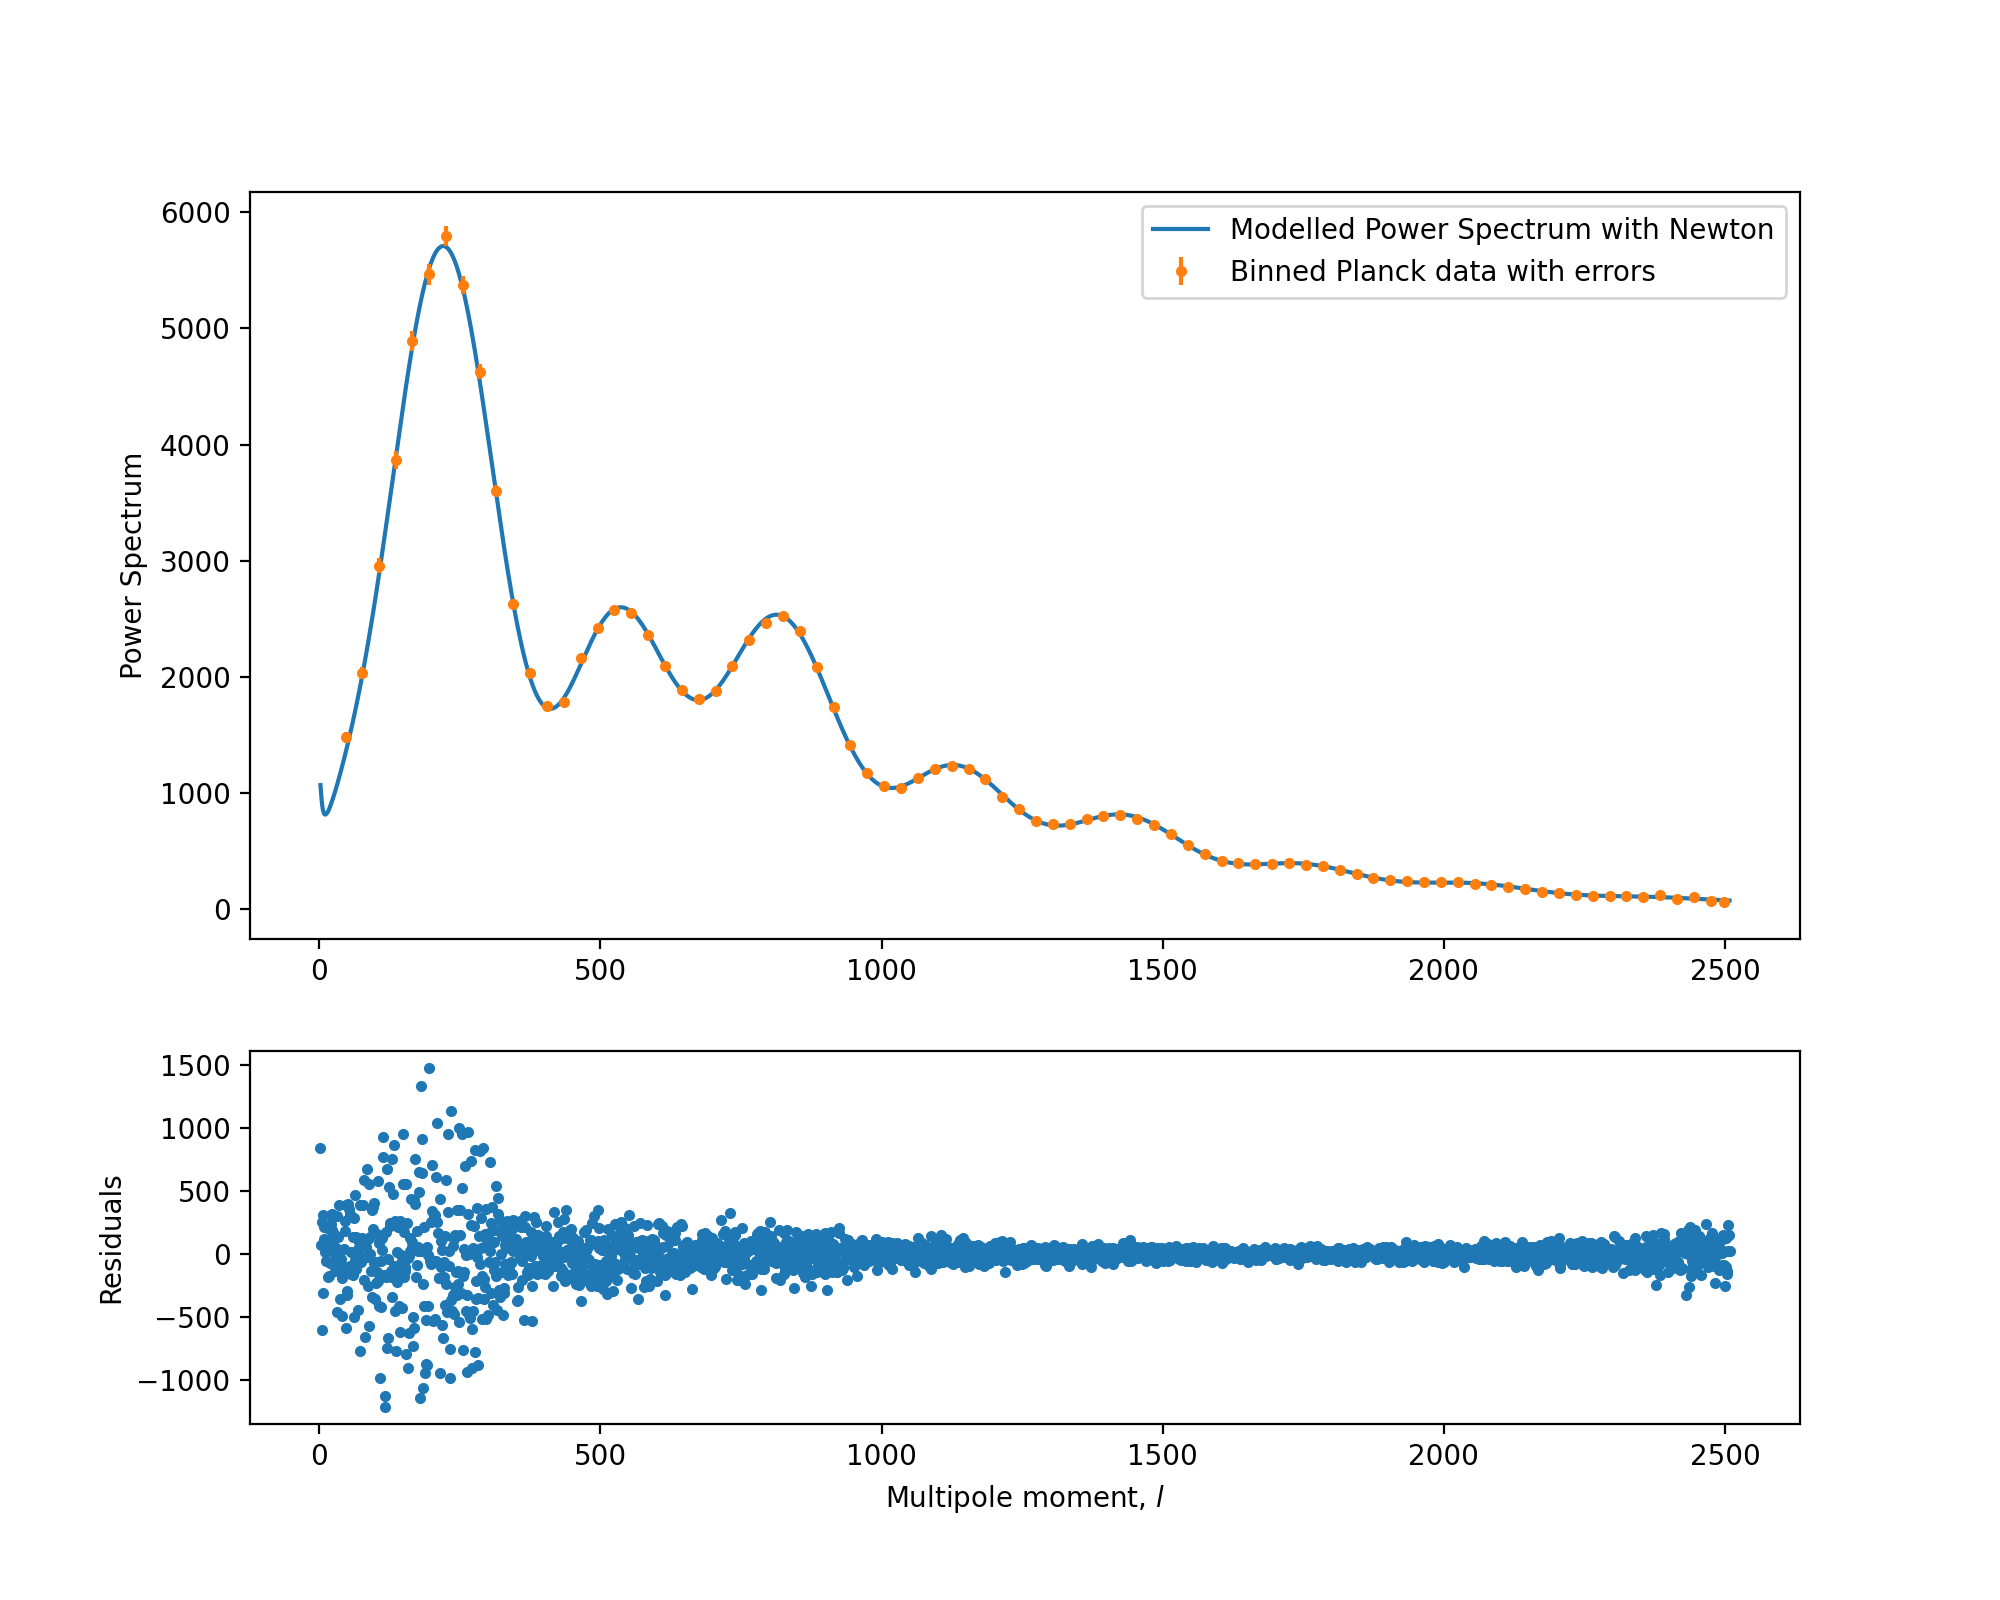

Text(0, 0.5, 'Residuals')

In [22]:
#Let's plot Newton's method fit to the data
fig,axs = plt.subplots(2,figsize=(10,8),gridspec_kw={'height_ratios':[2,1]})
res_newton = pred_newton-spec
axs[0].plot(l,pred_newton,label='Modelled Power Spectrum with Newton')
axs[0].errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.',label='Binned Planck data with errors')
axs[0].legend()
axs[0].set_ylabel('Power Spectrum')
axs[1].plot(l,res_newton,'.')
axs[1].set_xlabel('Multipole moment, $l$')
axs[1].set_ylabel('Residuals')

## C)

Now, we can run the MCMC chain using the best fit parameters from Newton as the first trial step and the covariance matrix obtained from newton to generate new steps in the MCMC. Again, MCMC was briefly explained in the previous assignment. So, I re-used the same function that I had for the previous assignment and adapted it for this new pset. 


In [23]:
def get_step(step_scale,cov):
    return np.random.multivariate_normal(np.zeros(cov[0].size),cov)*step_scale #step size is the scaling parameter  

def get_chisq2(data,model,err,p,lims):
    return np.sum((data-model)**2/err**2) + ((p-lims[0])/lims[1])**2 #Likelihood updated when we constrain a parameter

def run_mcmc(fun,pars,step_scale,spec,errs,cov,lmax=3000,nstep=20000,limtau=None):
    #name the file
    date = datetime.now().strftime("%Y_%m_%d")
    filename = f"Planck-Chain_{date}"
    
    acc=0 #number of steps accepted (i.e. if p > random number between 0 and 1)
    npar=len(pars)
    chain=np.zeros([nstep,npar+1]) #matrix of the parameters
    chain[0,:-1]=pars #first location is the guess parameters
    chi_cur=get_chisq(spec,fun(pars,lmax)[:len(spec)],errs) #compute the chi square
    chain[0,-1]=chi_cur
    for i in tqdm(range(1,nstep)): #will stop when the number of steps will be reached
        pp=pars+get_step(step_scale,cov) #take a trial step
        
        if limtau is not None: #new likelihood if we constrain the parameter tau
            new_chisq=get_chisq2(spec,fun(pp,lmax)[:len(spec)],errs,pp[3],limtau)
        else:
            new_chisq=get_chisq(spec,fun(pp,lmax)[:len(spec)],errs) #compute new chi square
        
        accept_prob=np.exp(-0.5*(new_chisq-chi_cur)) #compute prob 
        
        if np.random.rand(1)<accept_prob: #step is accepted if True
            pars=pp 
            chi_cur=new_chisq
            acc += 1 #updated the number of accepted parameters
        chain[i,:-1]=pars
        chain[i,-1]=chi_cur
        np.savetxt(filename,chain)
        
    print('The ratio of accepted steps is {}.'.format(f'{acc/nstep:.2}'))
    return chain[:,:-1],chain[:,-1]  #return the chain of the parameters and the Chi-Square



In [ ]:
#Run the first Chain
step_scale=1
nsteps=20000
chain,chisq = run_mcmc(get_spectrum,pars_newton,step_scale,spec,errs,pars_covNewton,nstep=nsteps)

#My ratio of accepted steps was 0.17 which is lower than the optimal ratio (0.25) but still acceptable

In [24]:
#Download the first Chain
chain_chisq = np.loadtxt('Planck-Chain_2022_10_18')
chain = chain_chisq[:,0:-1]
chisq = chain_chisq[:,-1]


MCMC Results:


<IPython.core.display.Latex object>

68.35591185306959 ± 1.160617686194144



<IPython.core.display.Latex object>

0.022384561323455877 ± 0.00022676200873885207



<IPython.core.display.Latex object>

0.11745898461763161 ± 0.002589574259257087



<IPython.core.display.Latex object>

0.09021807870592498 ± 0.034145580911424035



<IPython.core.display.Latex object>

2.2437702864998996e-09 ± 1.4771008370436322e-10



<IPython.core.display.Latex object>

0.9740317142812357 ± 0.006504148605167532

With χ2 =  2578.6195314589077
Below are the chains of each parameters



<IPython.core.display.Javascript object>


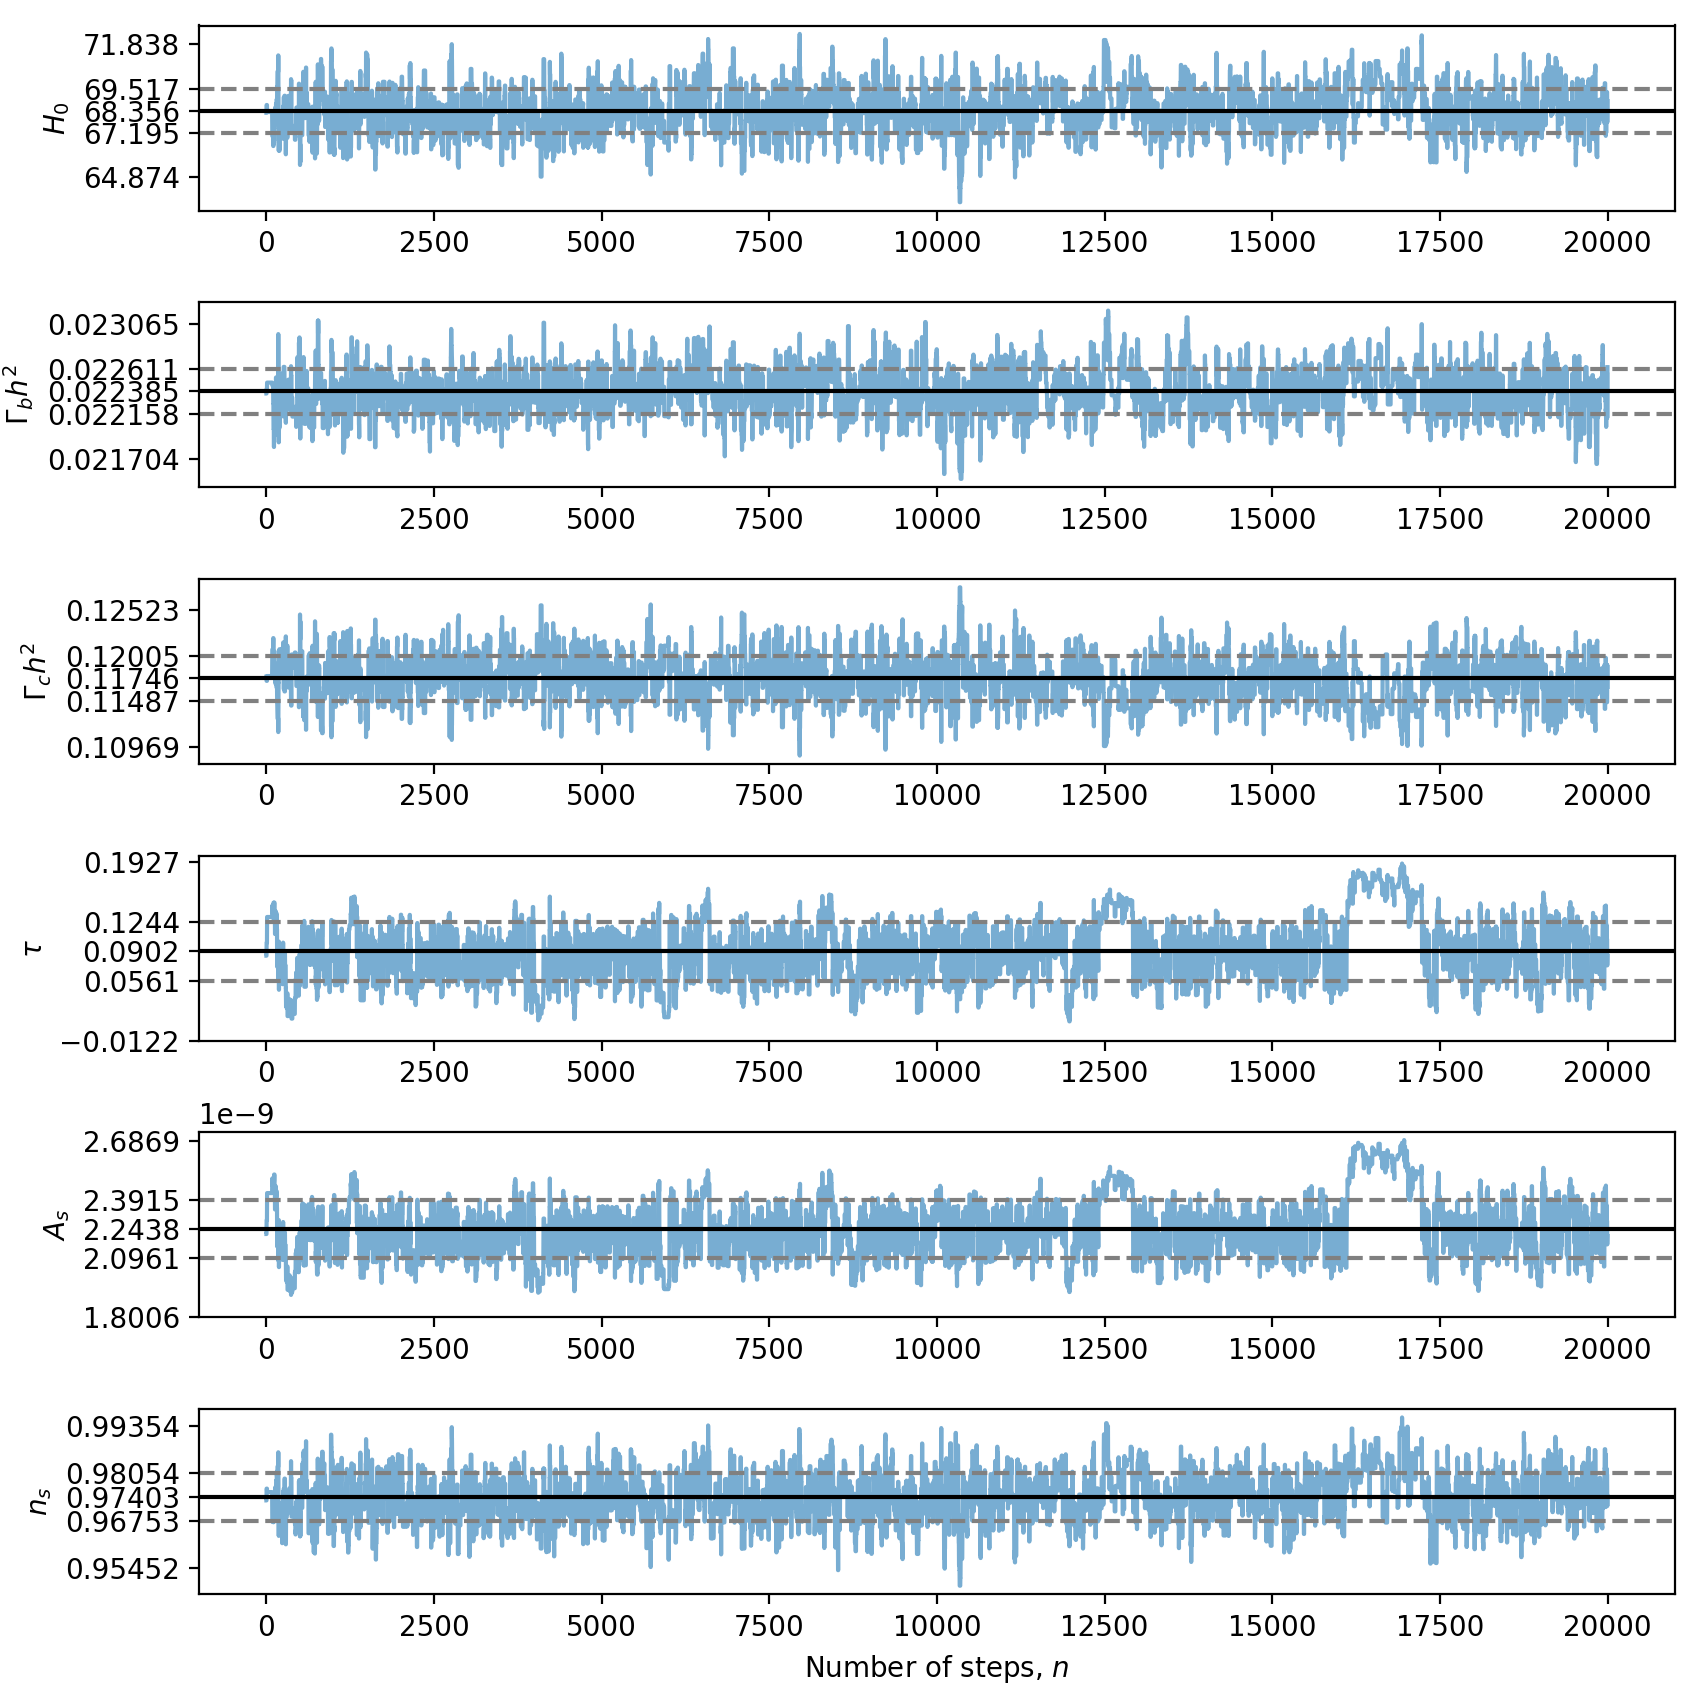

In [25]:
burn=0 #We don't have an evident burning phase so let's assume there is none
pars_mcmc = np.mean(chain[burn:],axis = 0) #parameters estimations using MCMC
errs_mcmc = np.std(chain[burn:],axis = 0) #assuming the chain converged, std is the error on the est. parameters
pred_mcmc = get_spectrum(pars_mcmc)[:len(spec)]
chisq_mcmc = get_chisq(pred_mcmc,spec,err_pnts)
print("MCMC Results:")
for i in range(len(pars_mcmc)):
    display(Latex(pars_name[i]))
    print("\b{} ± {}\n".format(pars_mcmc[i],errs_mcmc[i]))
print('With χ2 = ',chisq_mcmc)  
print('Below are the chains of each parameters\n')

fig,axs = plt.subplots(6,figsize=(10,10))
for i in range(len(pars_mcmc)):
    mean = pars_mcmc[i]
    std = errs_mcmc[i]
    axs[i].plot(chain[:,i],alpha=0.6)
    axs[i].axhline(y=mean+std,linestyle='--',color='gray')
    axs[i].axhline(y=mean,color='k')
    axs[i].axhline(y=mean-std,linestyle='--',color='gray')
    axs[i].set_ylabel(pars_name[i])
    axs[i].set_yticks([mean-3*std,mean-std,mean,mean+std,mean+3*std])
axs[-1].set_xlabel('Number of steps, $n$')
plt.tight_layout()
fig.set_size_inches(8.5,8.5)


In [26]:
#Compare Newton and MCMC:
for i in range(len(newtonpars)):
    display(Latex(pars_name[i]))
    print("MCMC: {} ± {}".format(f'{pars_mcmc[i]:.6}',f'{errs_mcmc[i]:.2}'))
    print("Newton: {} ± {}\n".format(f'{newtonpars[i,0]:.6}',f'{newtonpars[i,1]:.2}'))
display(Latex('$\chi^2$'))
print("MCMC: {}".format(f'{chisq_mcmc:.6}'))
print("Newton: {}".format(f'{chisq_newton:.6}'))

<IPython.core.display.Latex object>

MCMC: 68.3559 ± 1.2
Newton: 68.2447 ± 1.2



<IPython.core.display.Latex object>

MCMC: 0.0223846 ± 0.00023
Newton: 0.022364 ± 0.00023



<IPython.core.display.Latex object>

MCMC: 0.117459 ± 0.0026
Newton: 0.117662 ± 0.0026



<IPython.core.display.Latex object>

MCMC: 0.0902181 ± 0.034
Newton: 0.0852895 ± 0.034



<IPython.core.display.Latex object>

MCMC: 2.24377e-09 ± 1.5e-10
Newton: 2.21866e-09 ± 1.4e-10



<IPython.core.display.Latex object>

MCMC: 0.974032 ± 0.0065
Newton: 0.973058 ± 0.0065



<IPython.core.display.Latex object>

MCMC: 2578.62
Newton: 2576.15


Comparing the two results, we see that the parameters differ between MCMC and Newton, but the errors remain pretty similar. The 𝜒2 also differ slightly. This suggests that we might not have the best fit parameters and should not stop here. 

We can use the FFT plots to better assess if the chain converged.


<IPython.core.display.Javascript object>


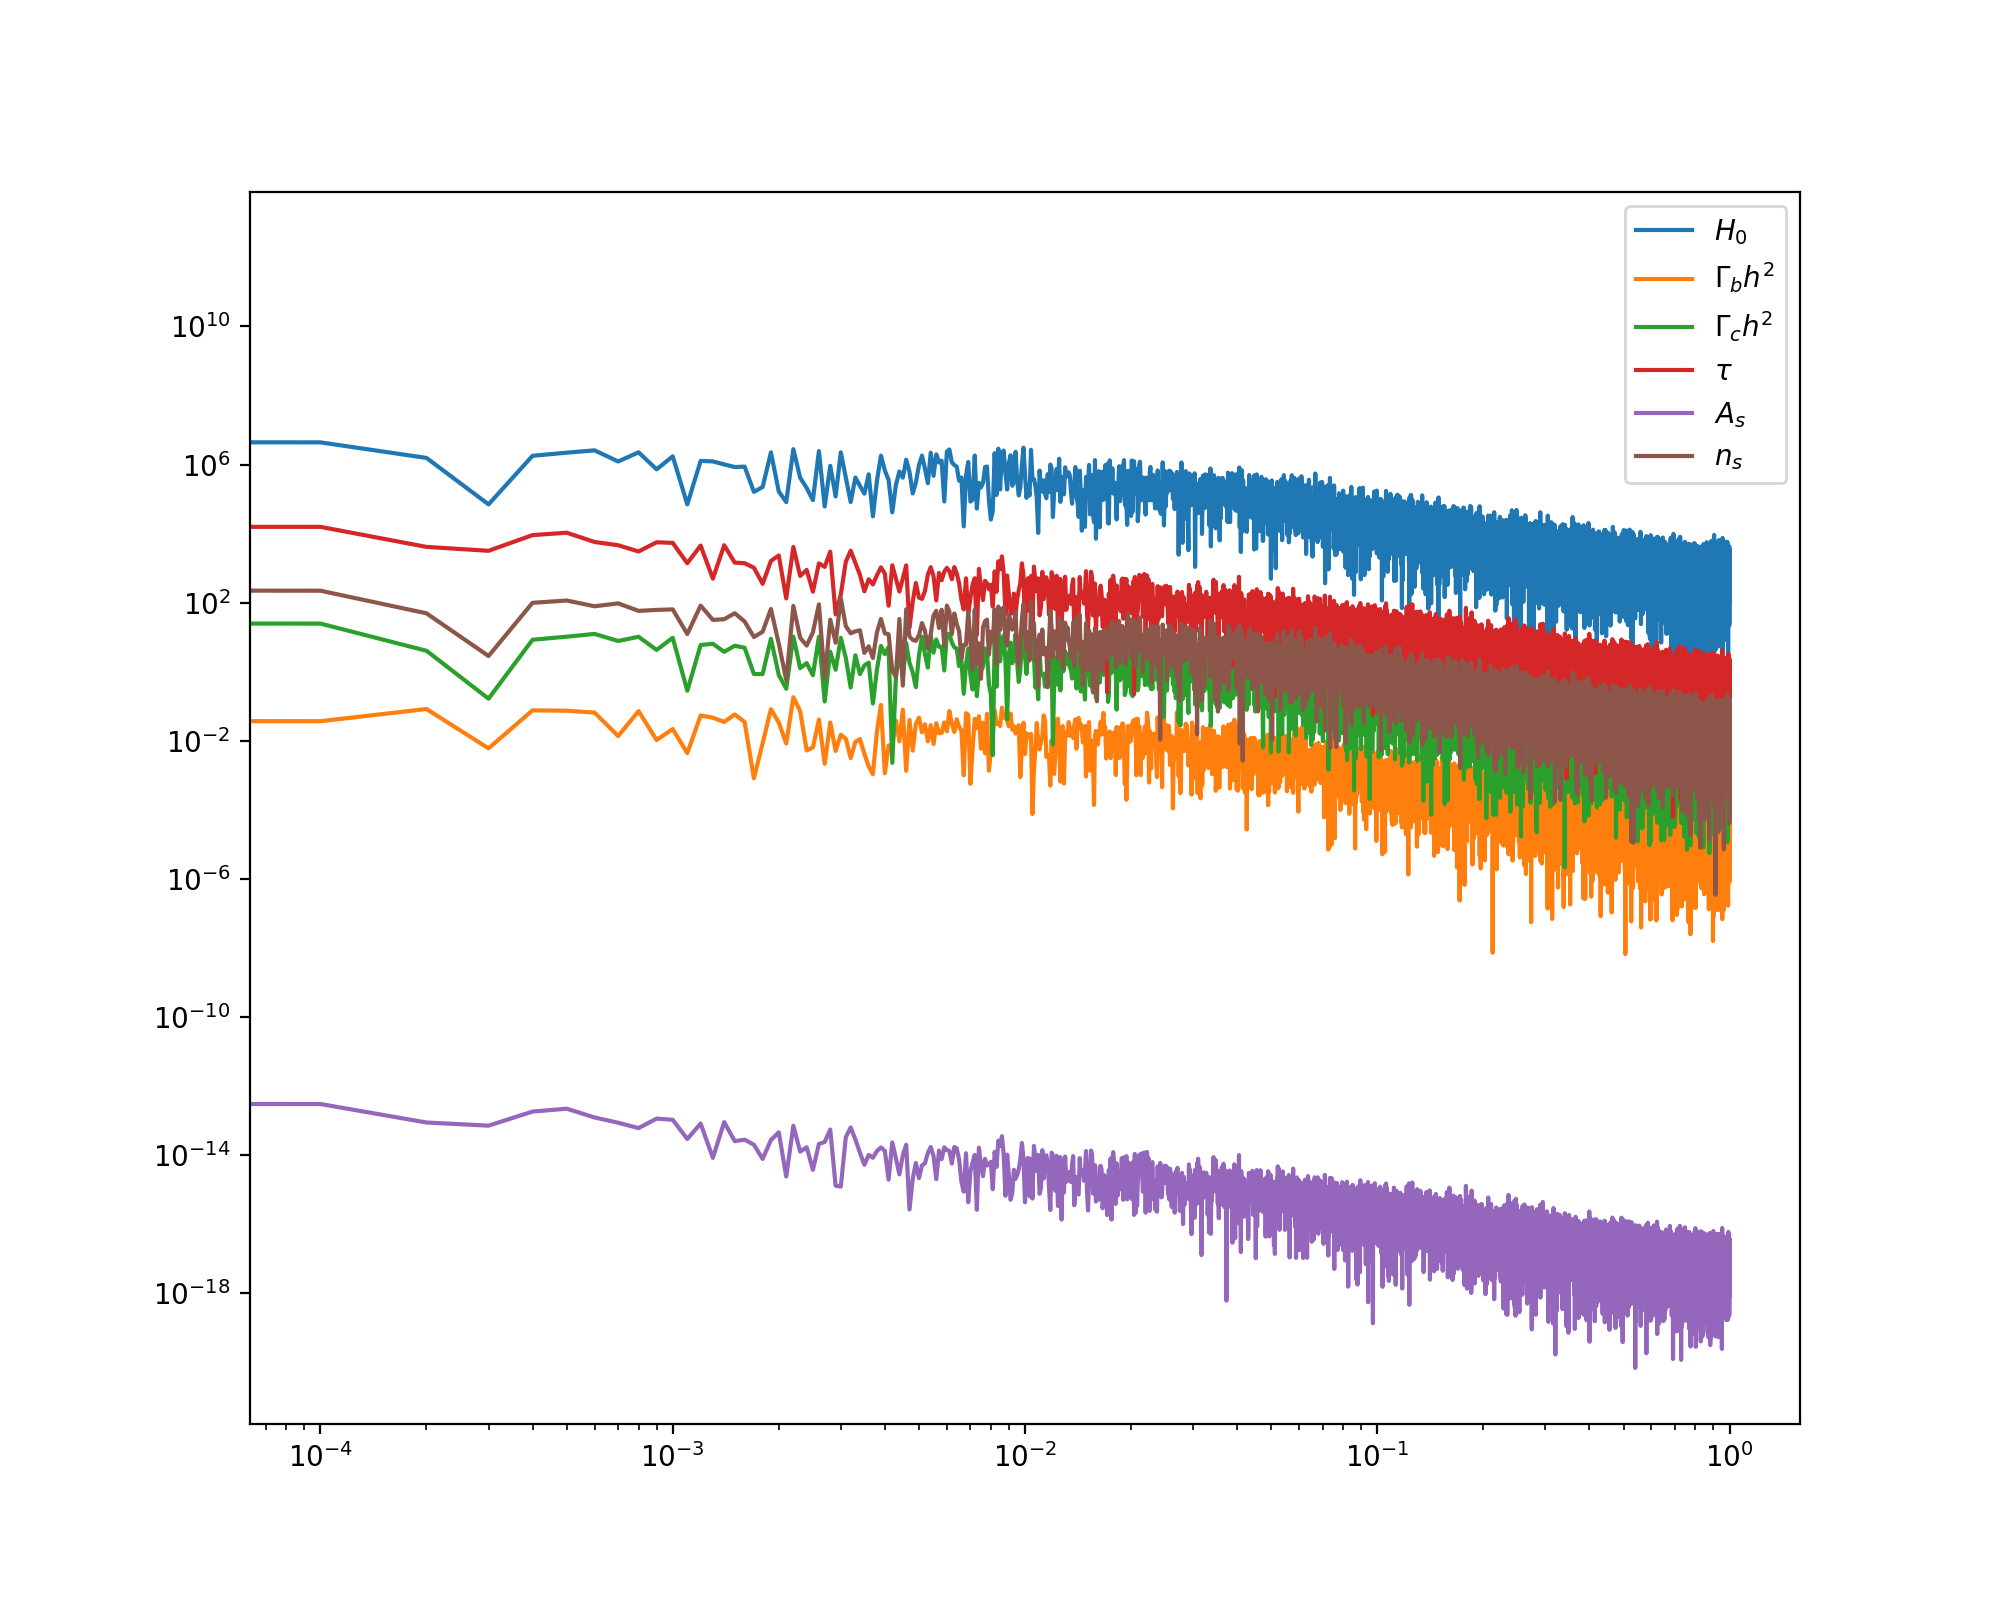

In [27]:
plt.figure(figsize=(10,8))
for i in range(len(pars_mcmc)):
    psd = np.abs(np.fft.rfft(chain[:,i]))**2
    plt.loglog(np.linspace(0,1,len(psd)),psd,label=pars_name[i])
plt.legend()


I am not sure if I can say the FFT plots are mostly flat on the x axis for $\tau$ and $A_s$ as they don't seem to be exactly flat but rather have a small negative slope on the first half of the x axis. I am not sure if I can say that this suggest that the chain did not converge. However, I think it suggests further investigation.

* Also if we simply look at the individual chains for $\tau$ and $A_s$, there are significant jumps near the tail of the chain that don't look like white noise to me.

* Looking at the chain with corner, $\tau$ and $A_s$ don't seem to have a perfect gaussian distribution which is also indicating that the chain has probably not converged.

<IPython.core.display.Javascript object>


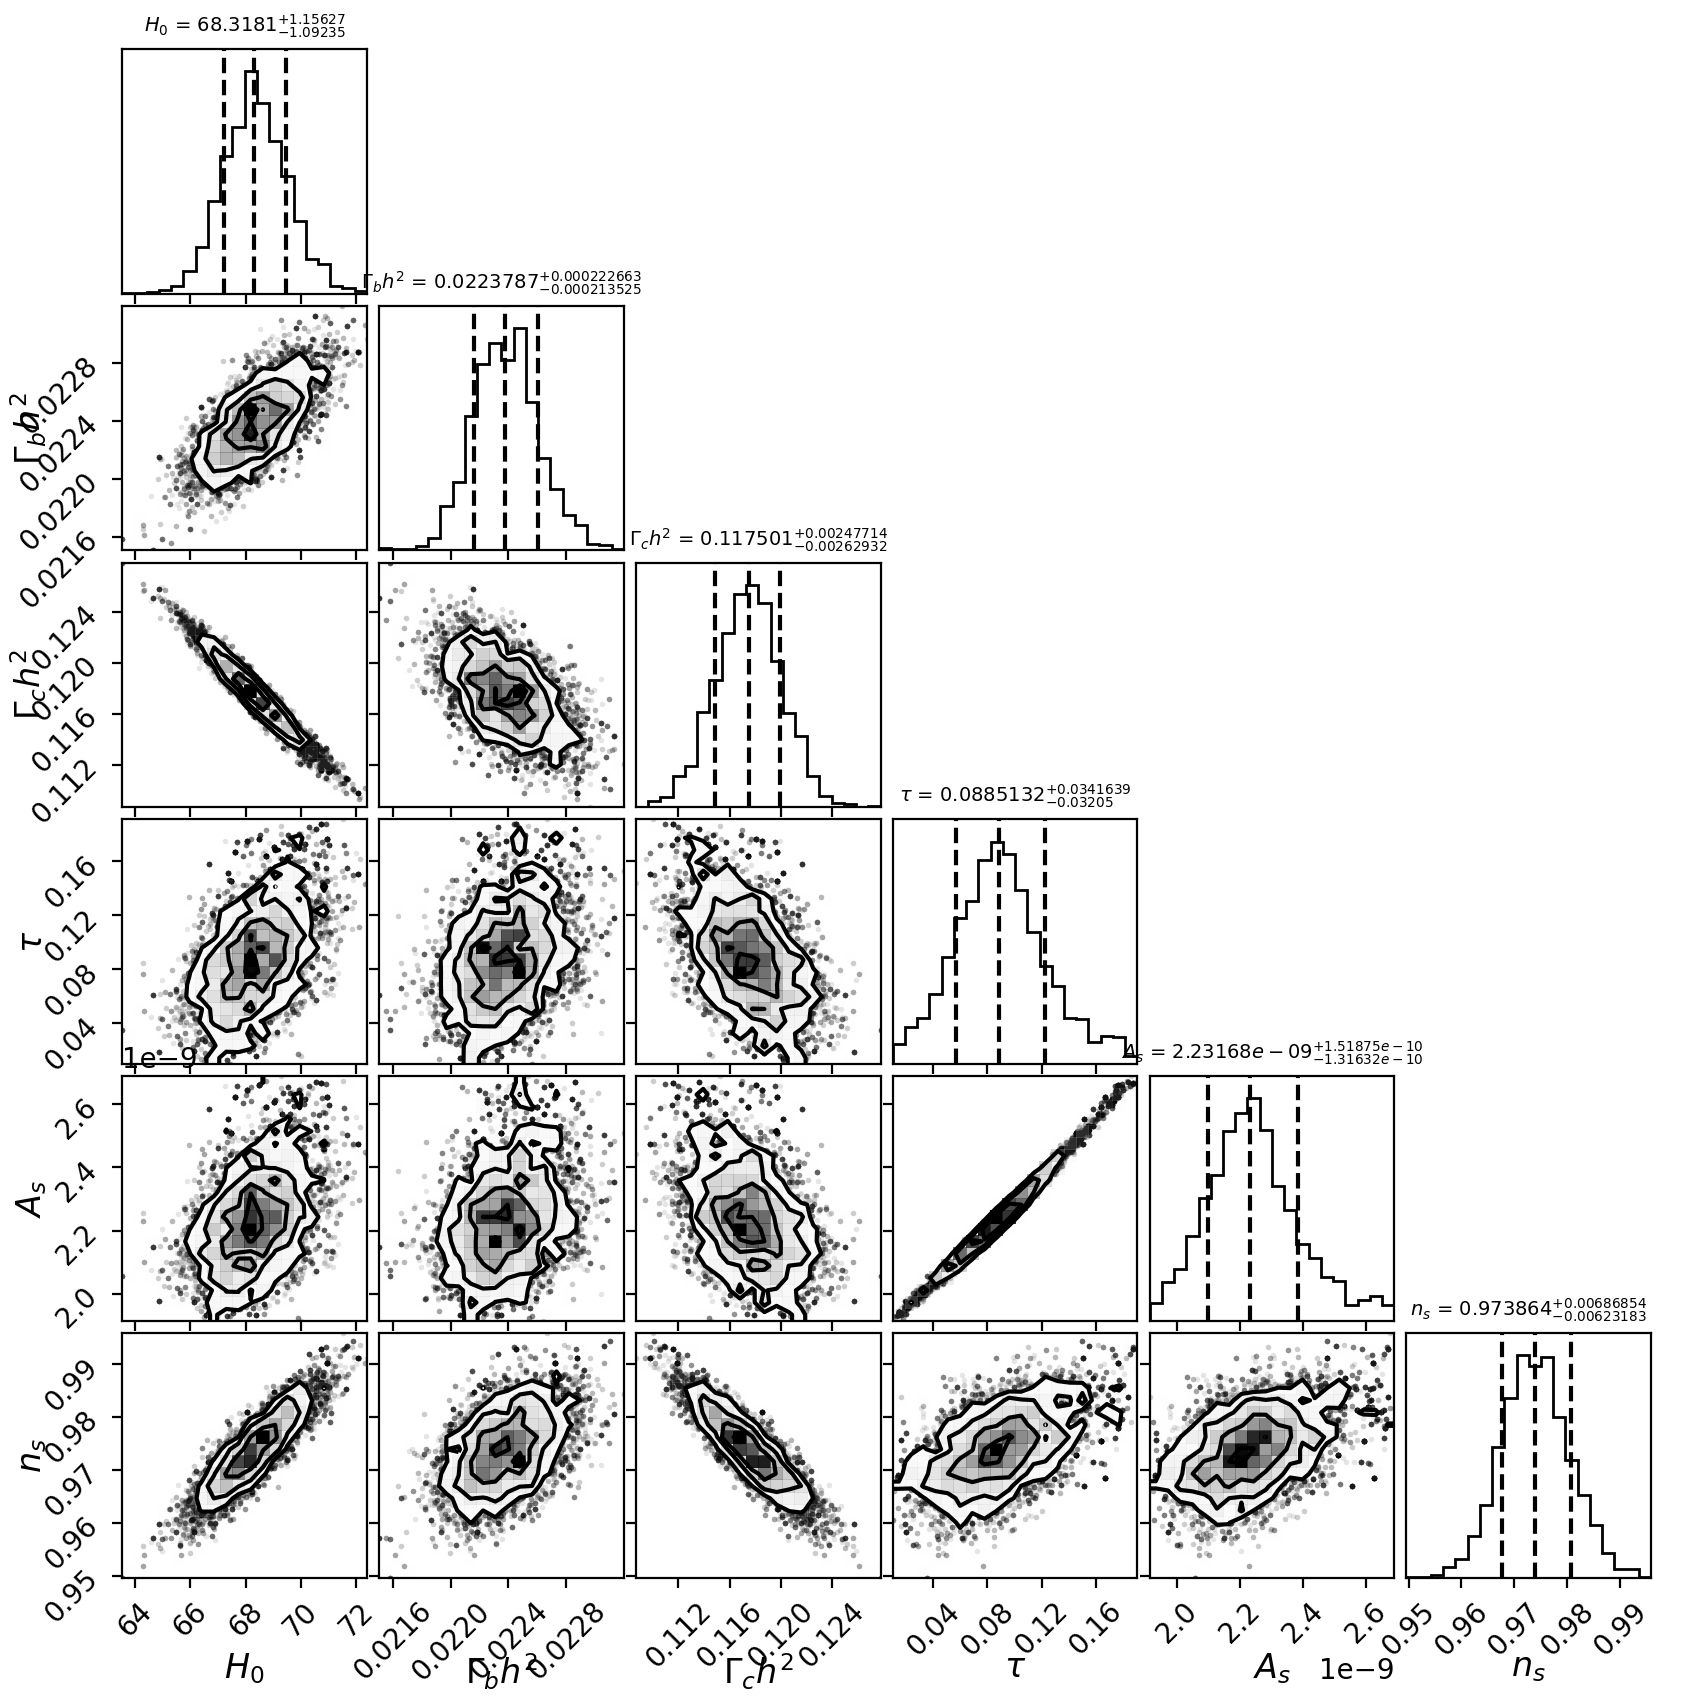

In [28]:
fig=corner.corner(chain,labels=pars_name,label_kwargs=dict(fontsize=12),quantiles = [0.16,.5,.84],
              show_titles=True,title_fmt='g',title_kwargs = dict(fontsize = 7)) 
fig.set_size_inches(8.5,8.5)

Nevertheless, let's still estimate the mean value on the dark energy, $\Omega_{DE}$ and its uncertainty. Assuming the univers is spatially flat we have  $\Omega_b + \Omega_c + \Omega_{DE} = 1$ such that  $\Omega_{DE} = 1-\Omega_b - \Omega_c $

Also, assuming the chain converged, we can have "new parameters chains" by algrebaically manipulating other chains. Then, the mean of the "new" chain will be the "new" parameter value and similarly, its value will simply be the standard deviation of the "new" chain. So, since we have $H_0$, $\Omega_b h^2$ and $\Omega_c h^2$, where $h=H_0/100$, we can simply take $\Omega_{b,c}$ as the new chains $\Omega_{b,c} h^2 / (H_0/100)^2$. Then, the error on $\Omega_{DE}$ is simply the sum of $\sigma_{\Omega_b}$ and $\sigma_{\Omega_c}$ by error propagation.

In [29]:
#estimate dark energy
om_bs = chain[:,1]/((chain[:,0]/100)**2)
om_b_mean = np.mean(om_bs)
om_b_std = np.std(om_bs)

om_cs = chain[:,2]/((chain[:,0]/100)**2)
om_c_mean = np.mean(om_cs)
om_c_std = np.std(om_cs)

om_d = 1 - om_c_mean - om_b_mean
om_d_err = om_c_std+om_b_std

print('The estimate on the mean value of dark energy is: ',f'{om_d:.4}','±',f'{om_d_err:.2}')


The estimate on the mean value of dark energy is:  0.7003 ± 0.015


## C)

The idea is to compare importance sampling the chain that we already ran with a new chain for which we put a constraint on the parameter $\tau$. 

About importance sampling:
We include new information by modifying the likelihood of each steps taken in the chain that we have (where previously, the likelihood was simply given by 𝜒2). This way, we can weight each steps, given the new likelihood, and get the new distribution of the parameters by simply taking a weighted average

About the new chain:
The idea is similar as above but instead we direclty compute the likelihood as the new likelihood (given the constraint) for each new step taken such that the probability of taking a new step is directly linked with the new likelihood. 

In both cases, the new likelihood, referred as the new $\chi^2$, is given by the old $\chi^2$ plus $\tau$'s likelihood given what should be its mean and standard deviation. In other words:

$\chi^2_{new} = \sum{(\frac{o_i-e_i}{\sigma_i})^2} + (\frac{\tau_{\text{trial}}-\tau_{\text{prior}}}{\sigma_{\tau}})^2$, (1)

where $o_i$ and $e_i$, are the observed data points and expected data points from the model, $\sigma_i$ is the error on $o_i$, $\tau_{\text{trial}}$ is $\tau$ at a given step of the chain, $\tau_{\text{prior}}$ is the expected $\tau$ (i.e. 0.054) and $\sigma_{\tau}$ is the standard deviation of the expected $\tau$ (i.e. 0.0074).

For importance sampling, we want to downweight by ratio which is done by computing the weights given by: $wt = \text{e}^{-\frac{\Delta \chi^2}{2}}$, where $\Delta \chi^2 = \chi^2_{\text{new}} - \chi^2_{\text{old}} = \sum{(\frac{o_i-e_i}{\sigma_i})^2} + (\frac{\tau_{\text{trial}}-\tau_{\text{prior}}}{\sigma_{\tau}})^2 - \sum{(\frac{o_i-e_i}{\sigma_i})^2} = (\frac{\tau_{\text{trial}}-\tau_{\text{prior}}}{\sigma_{\tau}})^2 $ such that
$wt = \text{e}^{-\frac{(\tau_{\text{trial}}-\tau_{\text{prior}})^2}{2\sigma_{\tau}^2}}$.

For the new chain, we compute the probability of taking the step as $\text{e}^{-\frac{\chi_{i}^2-\chi_{i-1}^2}{2}}$, where $\chi_{i}^2$ is the computed likelihood given by (1) with the parameters at step $i$, and similarly for $\chi_{i-1}^2$.

In [30]:
#Jon's code, adapted
def process_chain(chain,priorpar,sigmapar):
    dchi = np.array([((chain[i,3]-priorpar)/sigmapar)**2 for i in range(len(chain))]) #Δ𝜒2, modified likelihood

    #Calculate the mean
    #and standard deviation of the chain, but will also
    #return the weights so you could calculate whatever you want

    wt=np.exp(-0.5*dchi) #the magic line that importance samples
        
    #calculate the weighted sum of the chain and the chain squared
    npar=chain.shape[1]
    tot=np.zeros(npar)
    totsqr=np.zeros(npar)
    for i in range(npar):
        tot[i]=np.sum(wt*chain[:,i])
        totsqr[i]=np.sum(wt*chain[:,i]**2)
    #divide by sum or weights
    mean=tot/np.sum(wt)
    meansqr=totsqr/np.sum(wt)

    #variance is <x^2>-<x>^2
    var=meansqr-mean**2
    return mean,np.sqrt(var),wt

priortau = 0.054
stdtau = 0.0074
pars_imps,errs_imps,wts = process_chain(chain,priortau,stdtau)


In [31]:
pred_imps = get_spectrum(pars_imps)[:len(spec)]
chisq_imps = get_chisq(spec,pred_imps,err_pnts)

#print the importance sampled new parameters
print("Best fit parameters by importance Sampling the Chain")
for i in range(len(pars_imps)):
    display(Latex(pars_name[i]))
    print("{} ± {}".format(f'{pars_imps[i]:.6}',f'{errs_imps[i]:.2}'))
display(Latex('$\chi^2$'))
print(f'{chisq_imps:.8}')


Best fit parameters by importance Sampling the Chain


<IPython.core.display.Latex object>

67.7495 ± 1.0


<IPython.core.display.Latex object>

0.0223075 ± 0.00022


<IPython.core.display.Latex object>

0.118791 ± 0.0023


<IPython.core.display.Latex object>

0.0556363 ± 0.007


<IPython.core.display.Latex object>

2.09736e-09 ± 3.1e-11


<IPython.core.display.Latex object>

0.970403 ± 0.0058


<IPython.core.display.Latex object>

2577.064


In [32]:
#compute new covariance matrix with the steps of the chain, but weight the steps. Weights are from importance samp
wts = np.array(wts)
chain_matrix = np.matrix(chain)
pars_cov_imps = np.cov(chain_matrix.transpose(),aweights=wts)


Now we run the new chain with 
1) the new parameters covariance matrix given by importance sampling the previous chain

2) A new likelihood given by the constraint on $\tau$

In [ ]:
step_scale=1
nsteps=25000
taulims = [0.0540,0.0074]
#use the parameters for importance sampling as first guess
chain2,chisq2 = run_mcmc(get_spectrum,pars_imps,step_scale,spec,errs,pars_cov_imps,nstep=nsteps,limtau=taulims)


The ratio of accepted steps is 0.25 for this new chain which is the ideal ratio for mcmc!

We can now look if the chain converged.

In [33]:
#download from the file of the new chain
chain2 = np.loadtxt('Planck-Chain_2022_10_21')
chisq2 = chain2[:,-1]
chain2 = chain2[:,:-1]

MCMC with Constraint Results:


<IPython.core.display.Latex object>

67.72475383416605 ± 1.0094517839667771



<IPython.core.display.Latex object>

0.022292028227113632 ± 0.00021345751638663727



<IPython.core.display.Latex object>

0.11882522207417581 ± 0.002292973848121158



<IPython.core.display.Latex object>

0.05590235090203147 ± 0.007477566851787625



<IPython.core.display.Latex object>

2.0987150549386728e-09 ± 3.251267949031963e-11



<IPython.core.display.Latex object>

0.9703191173179976 ± 0.005534867693613026

With χ2 =  2577.04624231873
Below are the chains of each parameters



<IPython.core.display.Javascript object>


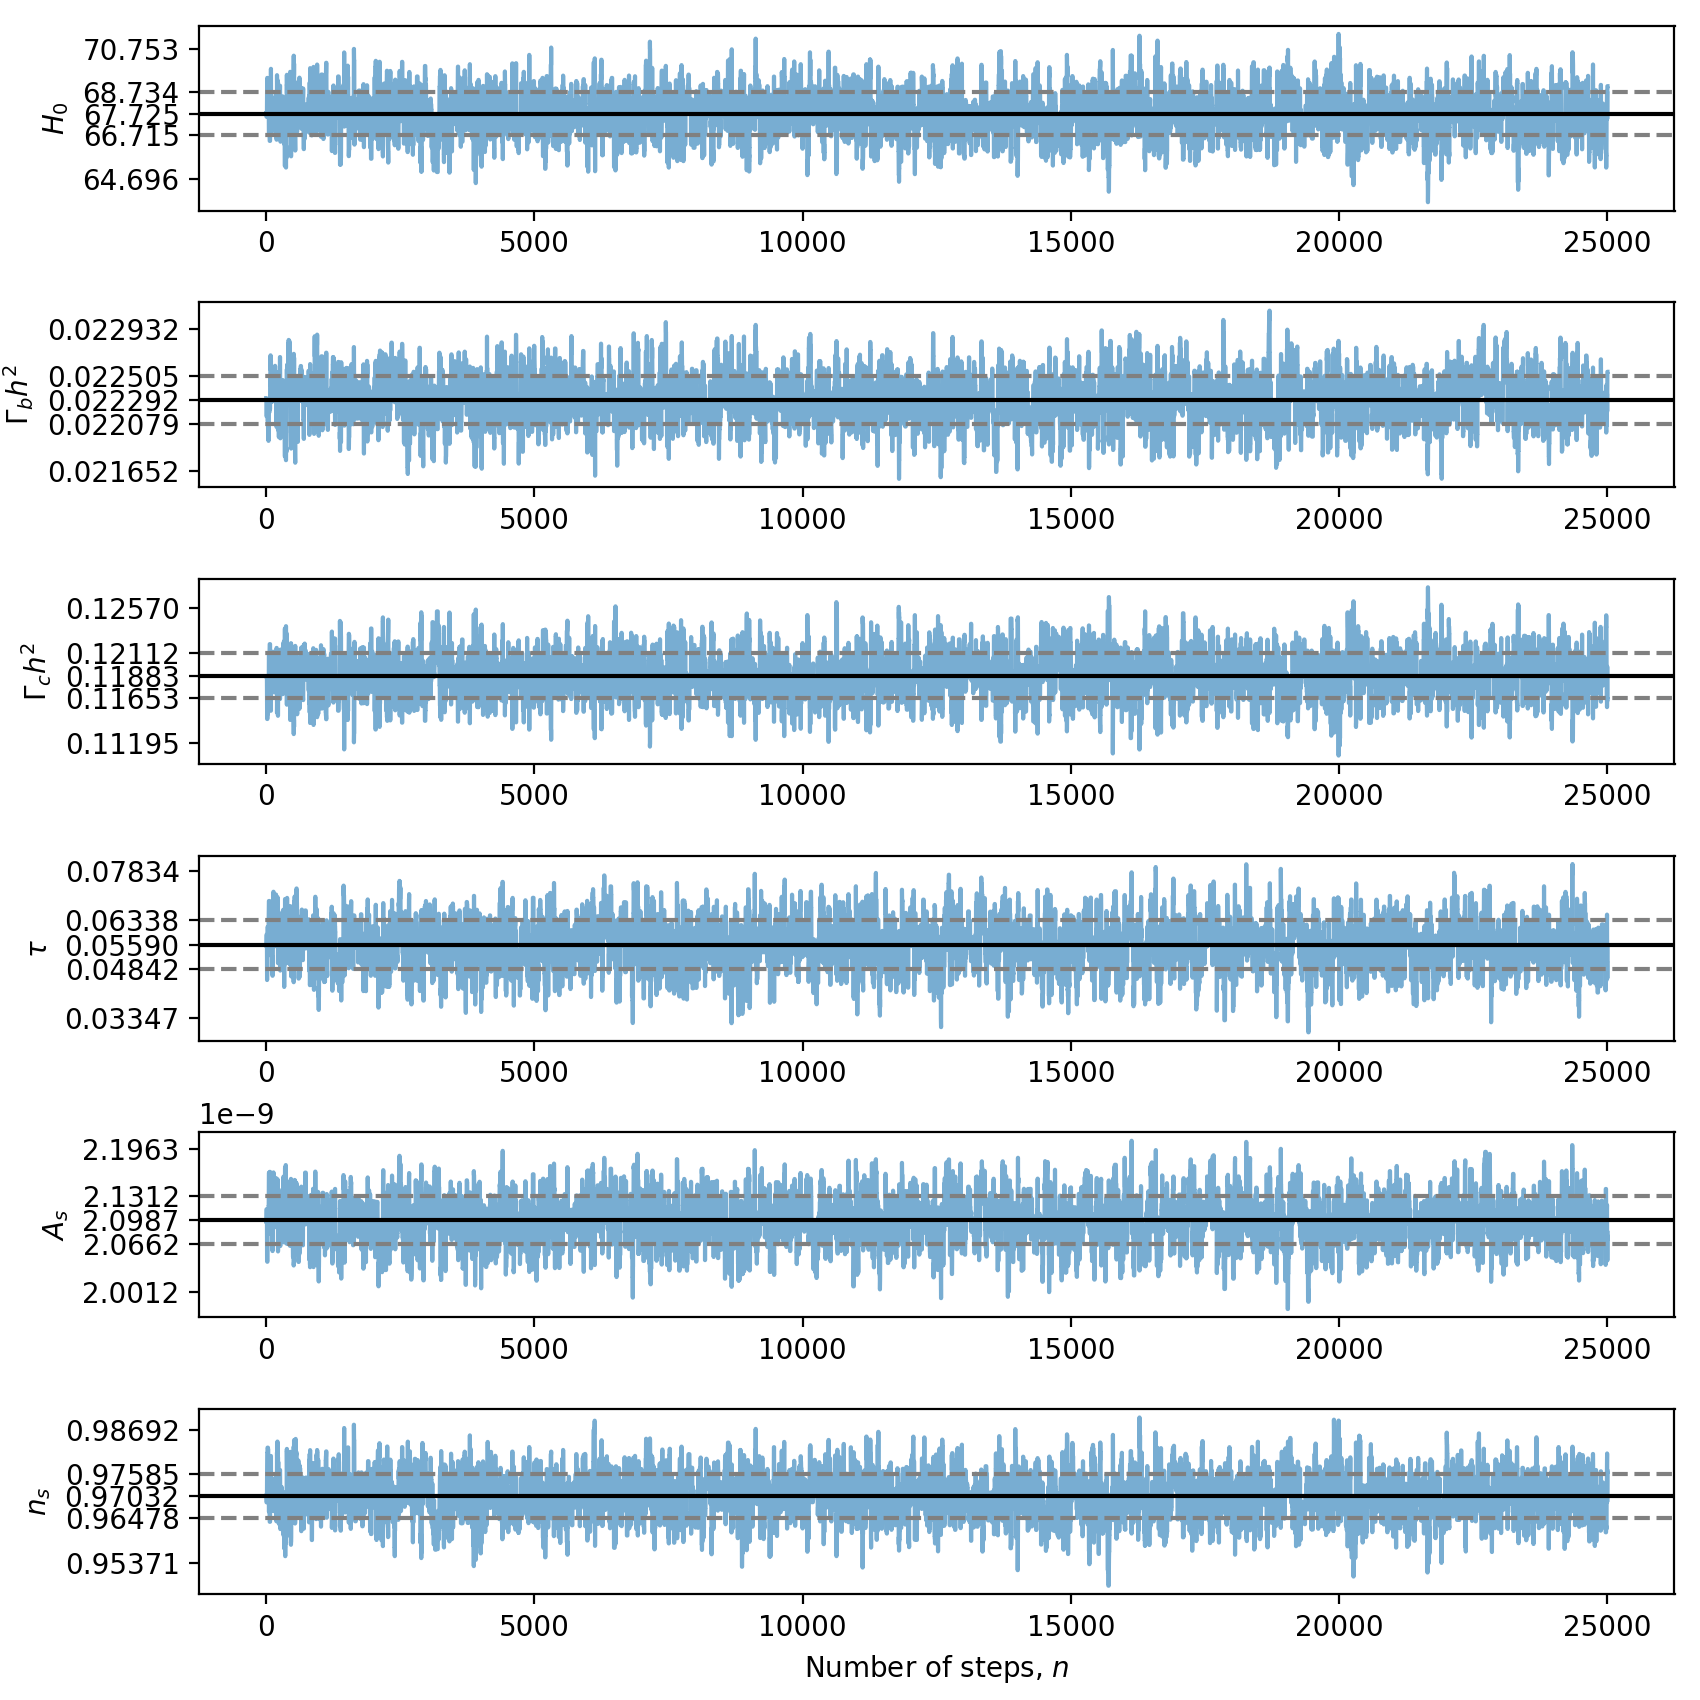

In [35]:
burn=0 #assuming no burning phase
pars_mcmc2 = np.mean(chain2[burn:],axis = 0)
errs_mcmc2 = np.std(chain2[burn:],axis = 0)
pred_mcmc2 = get_spectrum(pars_mcmc2)[:len(spec)]
chisq_mcmc2 = get_chisq(pred_mcmc2,spec,err_pnts)

print("MCMC with Constraint Results:")
for i in range(len(pars_mcmc)):
    display(Latex(pars_name[i]))
    print("\b{} ± {}\n".format(pars_mcmc2[i],errs_mcmc2[i]))
print('With χ2 = ',chisq_mcmc2)  
print('Below are the chains of each parameters\n')

fig,axs = plt.subplots(6,figsize=(10,10))
for i in range(len(pars_mcmc)):
    mean = pars_mcmc2[i]
    std = errs_mcmc2[i]
    axs[i].plot(chain2[:,i],alpha=0.6)
    axs[i].axhline(y=mean+std,linestyle='--',color='gray')
    axs[i].axhline(y=mean,color='k')
    axs[i].axhline(y=mean-std,linestyle='--',color='gray')
    axs[i].set_ylabel(pars_name[i])
    axs[i].set_yticks([mean-3*std,mean-std,mean,mean+std,mean+3*std])
axs[-1].set_xlabel('Number of steps, $n$')
plt.tight_layout()
fig.set_size_inches(8.5,8.5)

The chains look like white noise which is promising!

We can look at the FFT plots.

<IPython.core.display.Javascript object>


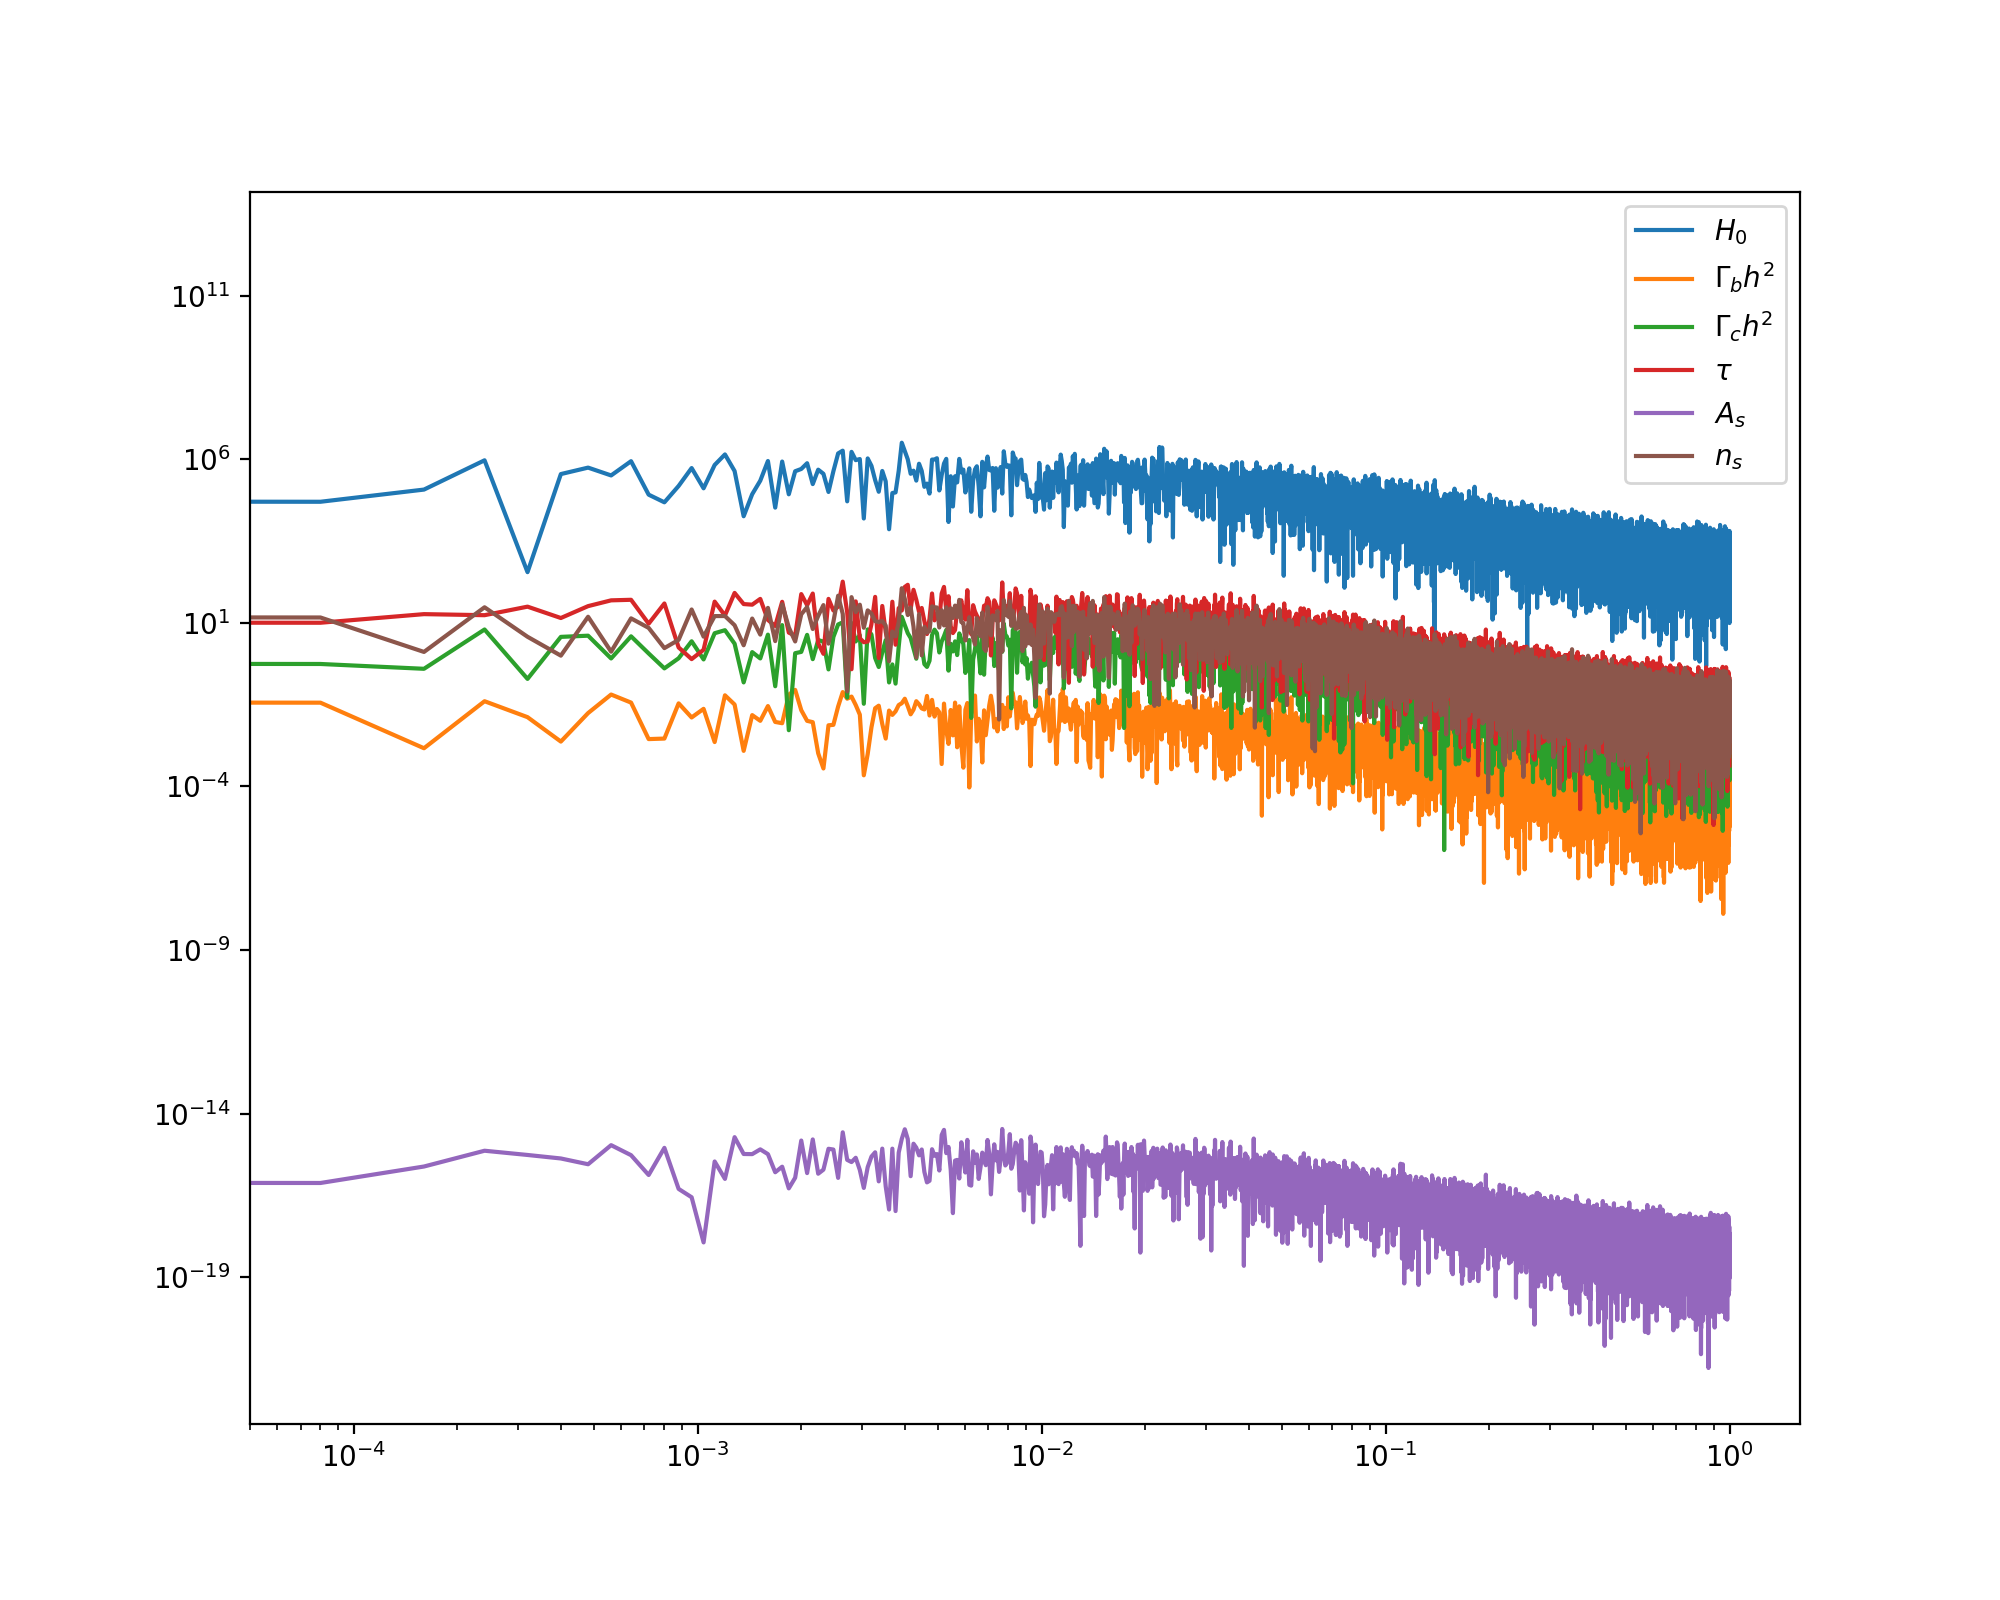

In [37]:
plt.figure(figsize=(10,8))
for i in range(len(pars_mcmc)):
    psd = np.abs(np.fft.rfft(chain2[:,i]))**2
    plt.loglog(np.linspace(0,1,len(psd)),psd,label=pars_name[i])
plt.legend()

The second MCMC run has most likely converged as the FFT Plots exhibit a flat power spectral density over a large portion of the x-axis!

Also, all parameters seem to have nice gaussian distributions from the analysis of corner :)

<IPython.core.display.Javascript object>


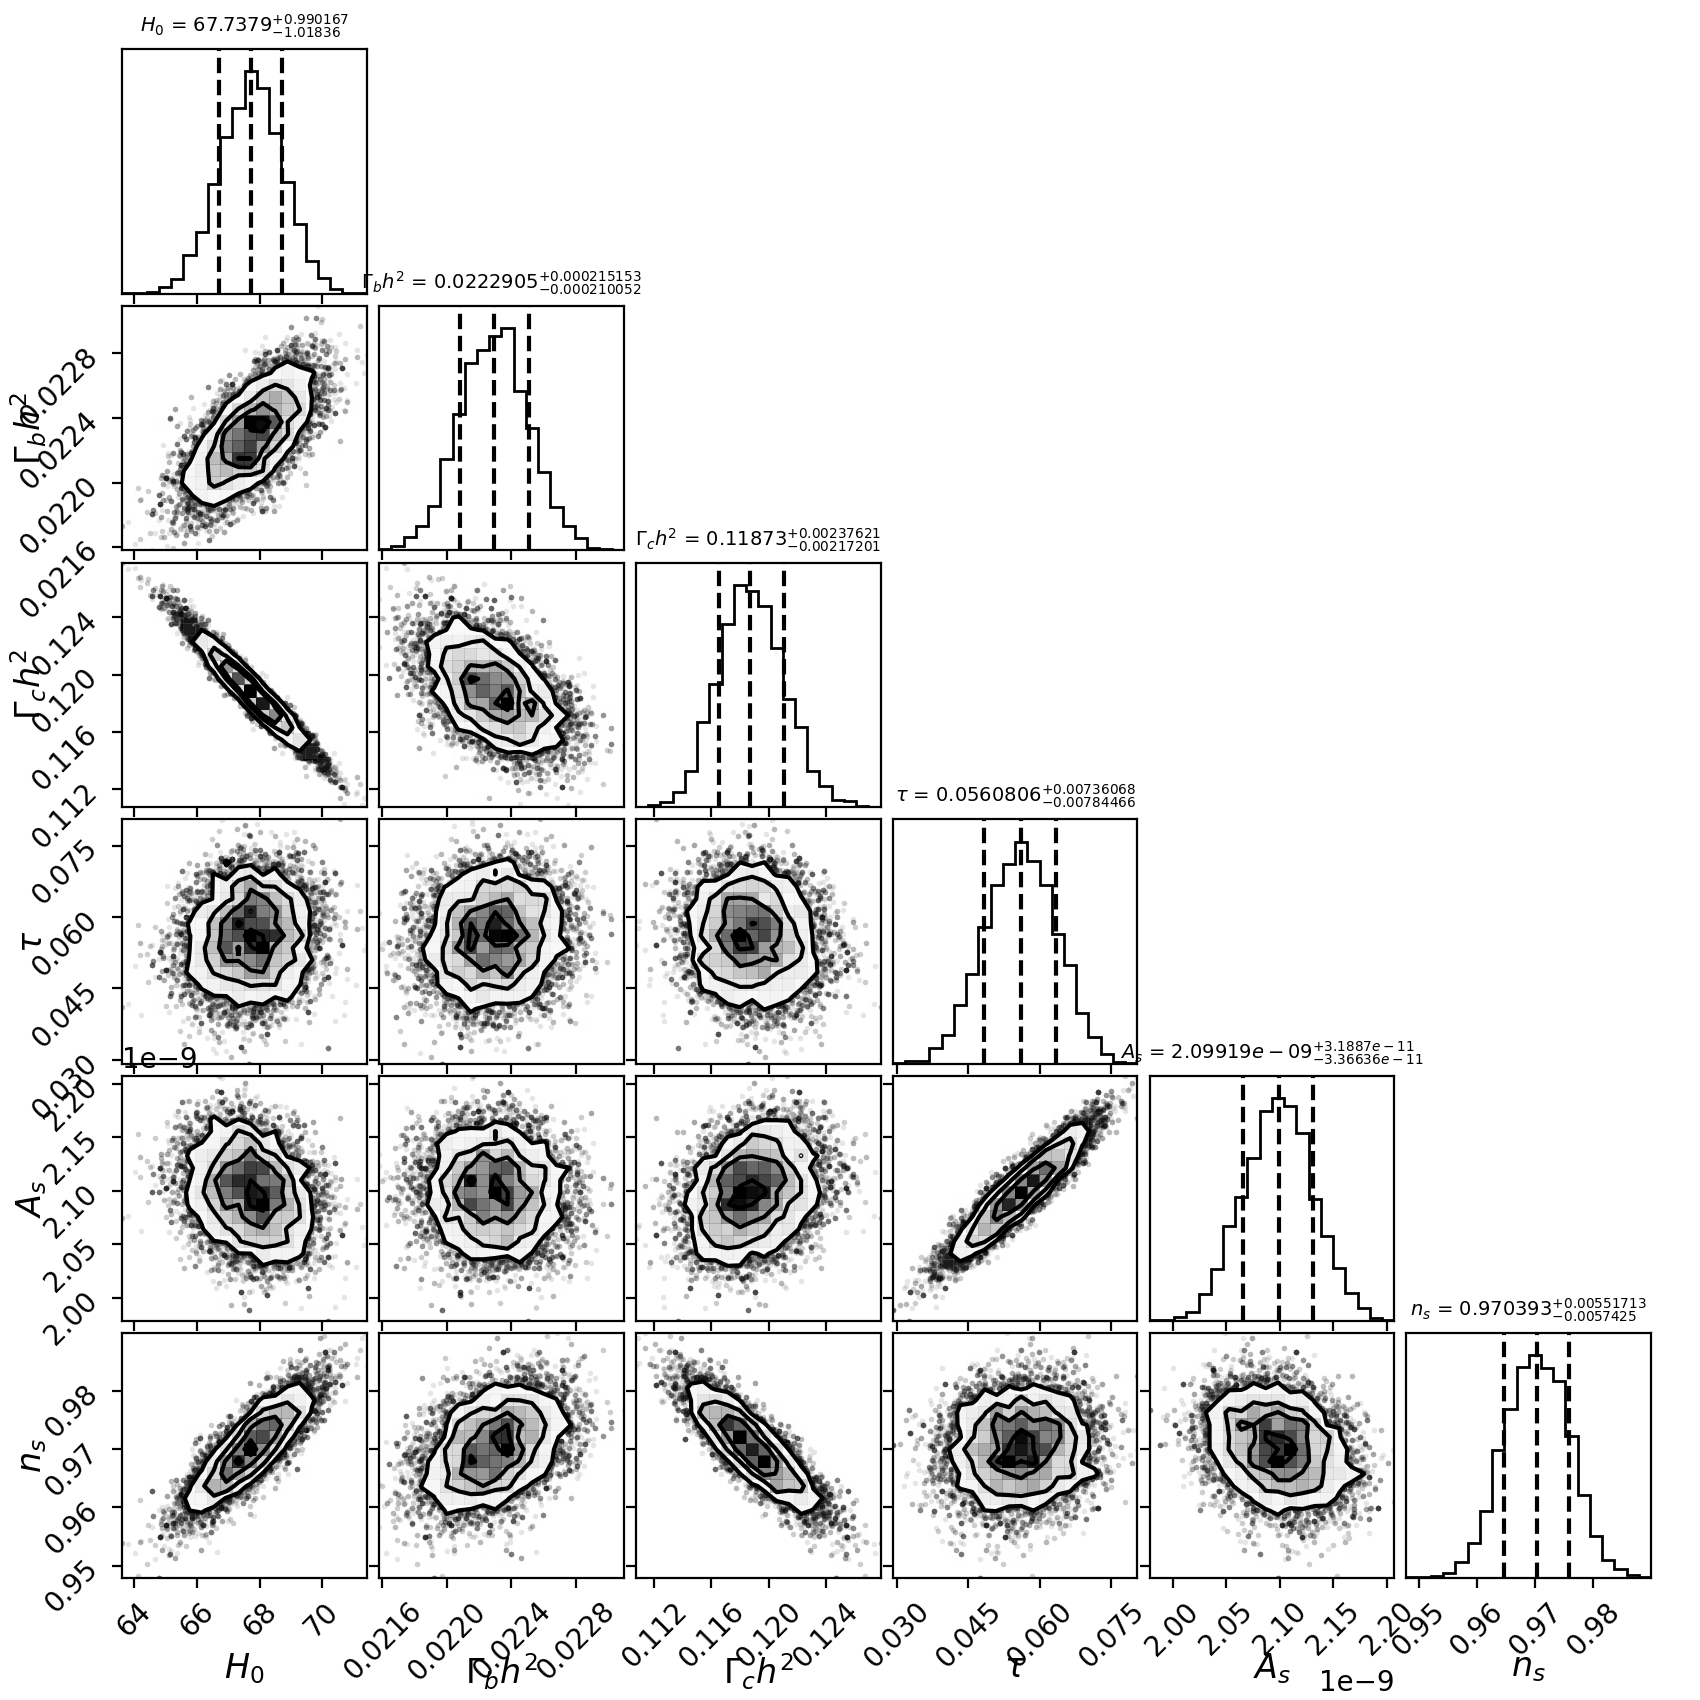

In [38]:
fig=corner.corner(chain2,labels=pars_name,label_kwargs=dict(fontsize=12),quantiles = [0.16,.5,.84],
              show_titles=True,title_fmt='g',title_kwargs = dict(fontsize = 7)) 
fig.set_size_inches(8.5,8.5)

In [39]:
# Compare the results from importance sampling and the second chain
for i in range(len(pars_name)):
    display(Latex(pars_name[i]))
    print("MCMC with constraint: {} ± {}".format(f'{pars_mcmc2[i]:.6}',f'{errs_mcmc2[i]:.2}'))
    print("Importance sampling: {} ± {}\n".format(f'{pars_imps[i]:.6}',f'{errs_imps[i]:.2}'))
display(Latex('$\chi^2$'))
print("MCMC with constraint: {}".format(f'{chisq_mcmc2:.6}'))
print("Importance sampling: {}".format(f'{chisq_imps:.6}'))

<IPython.core.display.Latex object>

MCMC with constraint: 67.7248 ± 1.0
Importance sampling: 67.7495 ± 1.0



<IPython.core.display.Latex object>

MCMC with constraint: 0.022292 ± 0.00021
Importance sampling: 0.0223075 ± 0.00022



<IPython.core.display.Latex object>

MCMC with constraint: 0.118825 ± 0.0023
Importance sampling: 0.118791 ± 0.0023



<IPython.core.display.Latex object>

MCMC with constraint: 0.0559024 ± 0.0075
Importance sampling: 0.0556363 ± 0.007



<IPython.core.display.Latex object>

MCMC with constraint: 2.09872e-09 ± 3.3e-11
Importance sampling: 2.09736e-09 ± 3.1e-11



<IPython.core.display.Latex object>

MCMC with constraint: 0.970319 ± 0.0055
Importance sampling: 0.970403 ± 0.0058



<IPython.core.display.Latex object>

MCMC with constraint: 2577.05
Importance sampling: 2577.06


The results are statistically the same, resulting in similar $\chi^2$. We can obviously conclude that importance sampling is a very powerfull tool!

<IPython.core.display.Javascript object>


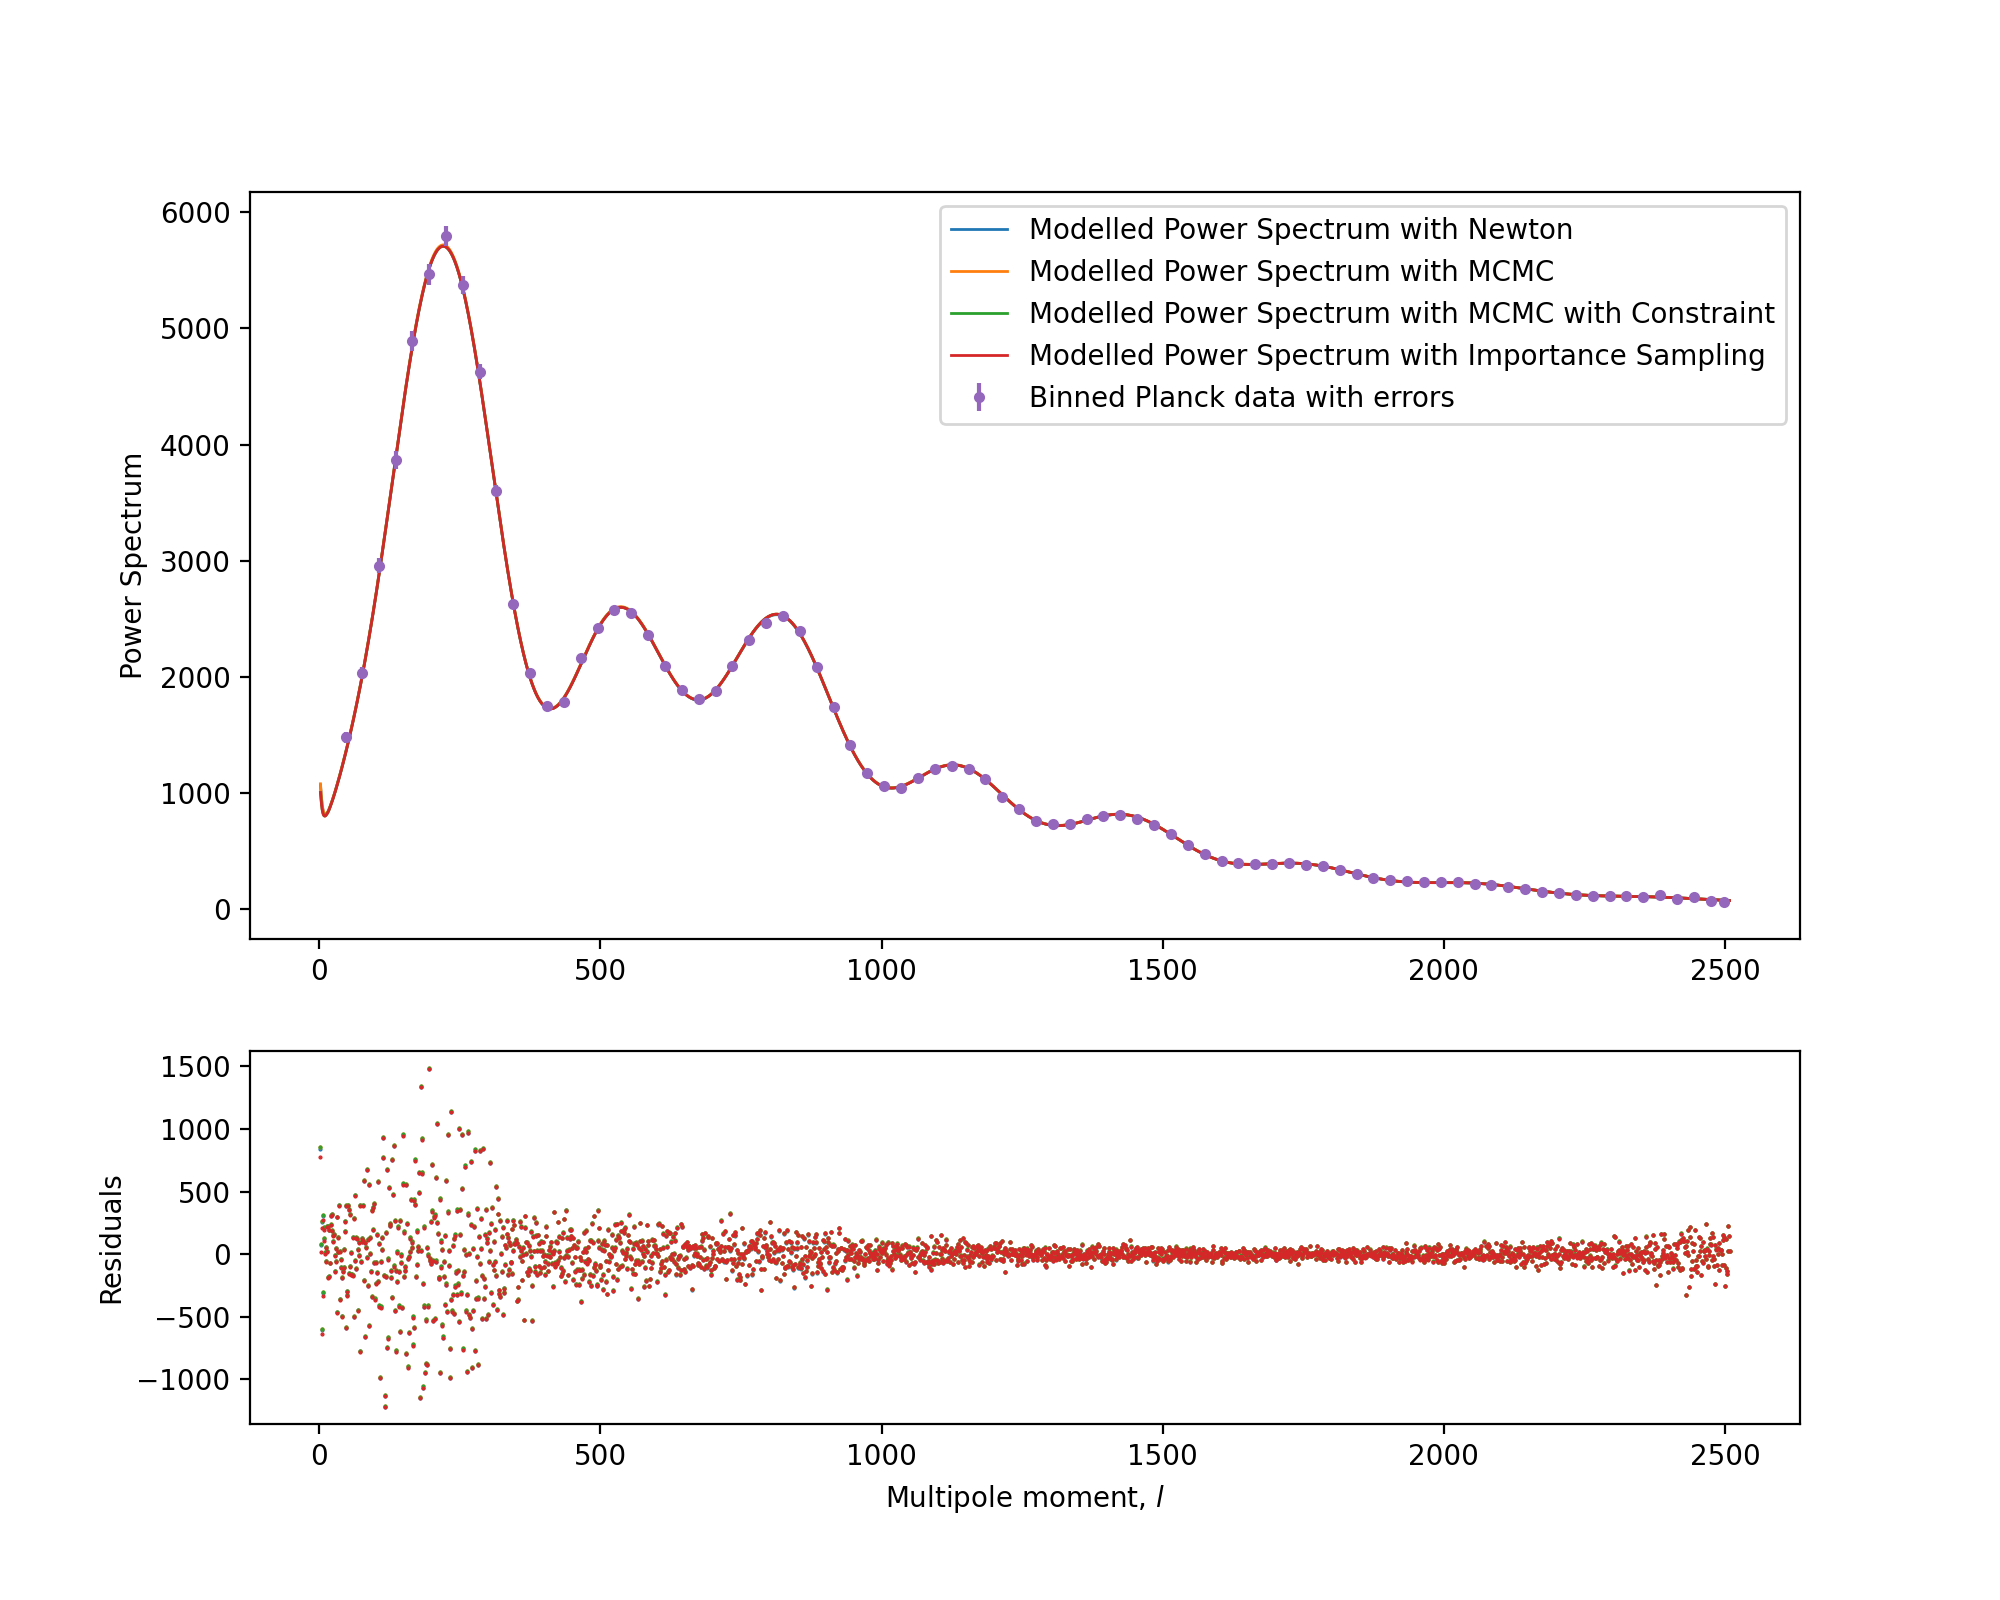

Text(0, 0.5, 'Residuals')

In [40]:
#plot all the results from the different methods/chains
res_newton = pred_newton - spec
res_mcmc = pred_mcmc - spec
res_mcmc2 = pred_mcmc - spec
res_imps = pred_imps - spec

fig,axs = plt.subplots(2,figsize=(10,8),gridspec_kw={'height_ratios':[2,1]})

axs[0].plot(l,pred_newton,label='Modelled Power Spectrum with Newton',linewidth=1)
axs[0].plot(l,pred_mcmc,label='Modelled Power Spectrum with MCMC',linewidth=1)
axs[0].plot(l,pred_mcmc2,label='Modelled Power Spectrum with MCMC with Constraint',linewidth=1)
axs[0].plot(l,pred_imps,label='Modelled Power Spectrum with Importance Sampling',linewidth=1)
axs[0].errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.',label='Binned Planck data with errors')
axs[0].legend()
axs[0].set_ylabel('Power Spectrum')

axs[1].plot(l,res_newton,'.',markersize=1)
axs[1].plot(l,res_mcmc,'.',markersize=1)
axs[1].plot(l,res_mcmc2,'.',markersize=1)
axs[1].plot(l,res_imps,'.',markersize=1)
axs[1].set_xlabel('Multipole moment, $l$')
axs[1].set_ylabel('Residuals')